In [1]:
import numpy as np

from IPython.display import display
from PIL import Image
from peewee import IntegerField, Model, CharField, SqliteDatabase, AutoField
import matplotlib.pyplot as plt

db = SqliteDatabase('events.db')


class Events(Model):
    id = AutoField()
    time = IntegerField()
    agent = CharField()
    event = CharField()
    participant_id = IntegerField()
    old_value = CharField(null=True)
    new_value = CharField(null=True)
    screenshot_file = CharField(null=True)

    class Meta:
        database = db

def show_screenshot_for_record(_id):
    events = Events.select().where(Events.id == _id).order_by(Events.time.asc()).limit(1)
    if len(events) == 0:
        print("No events found for id: ", _id)
        return
    event = events[0]
    image_path = event.screenshot_file
    print(_id)
    display(Image.open(image_path))


/Users/shady/Git/school/flow/apps/backend/velocityThreshold.py:62: RuntimeWarning: invalid value encountered in scalar divide
  rho = cov[0,1] / (sx*sy)
/Users/shady/Git/school/flow/apps/backend/utils.py:171: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(X_PIXELS / 100, Y_PIXELS / 100))


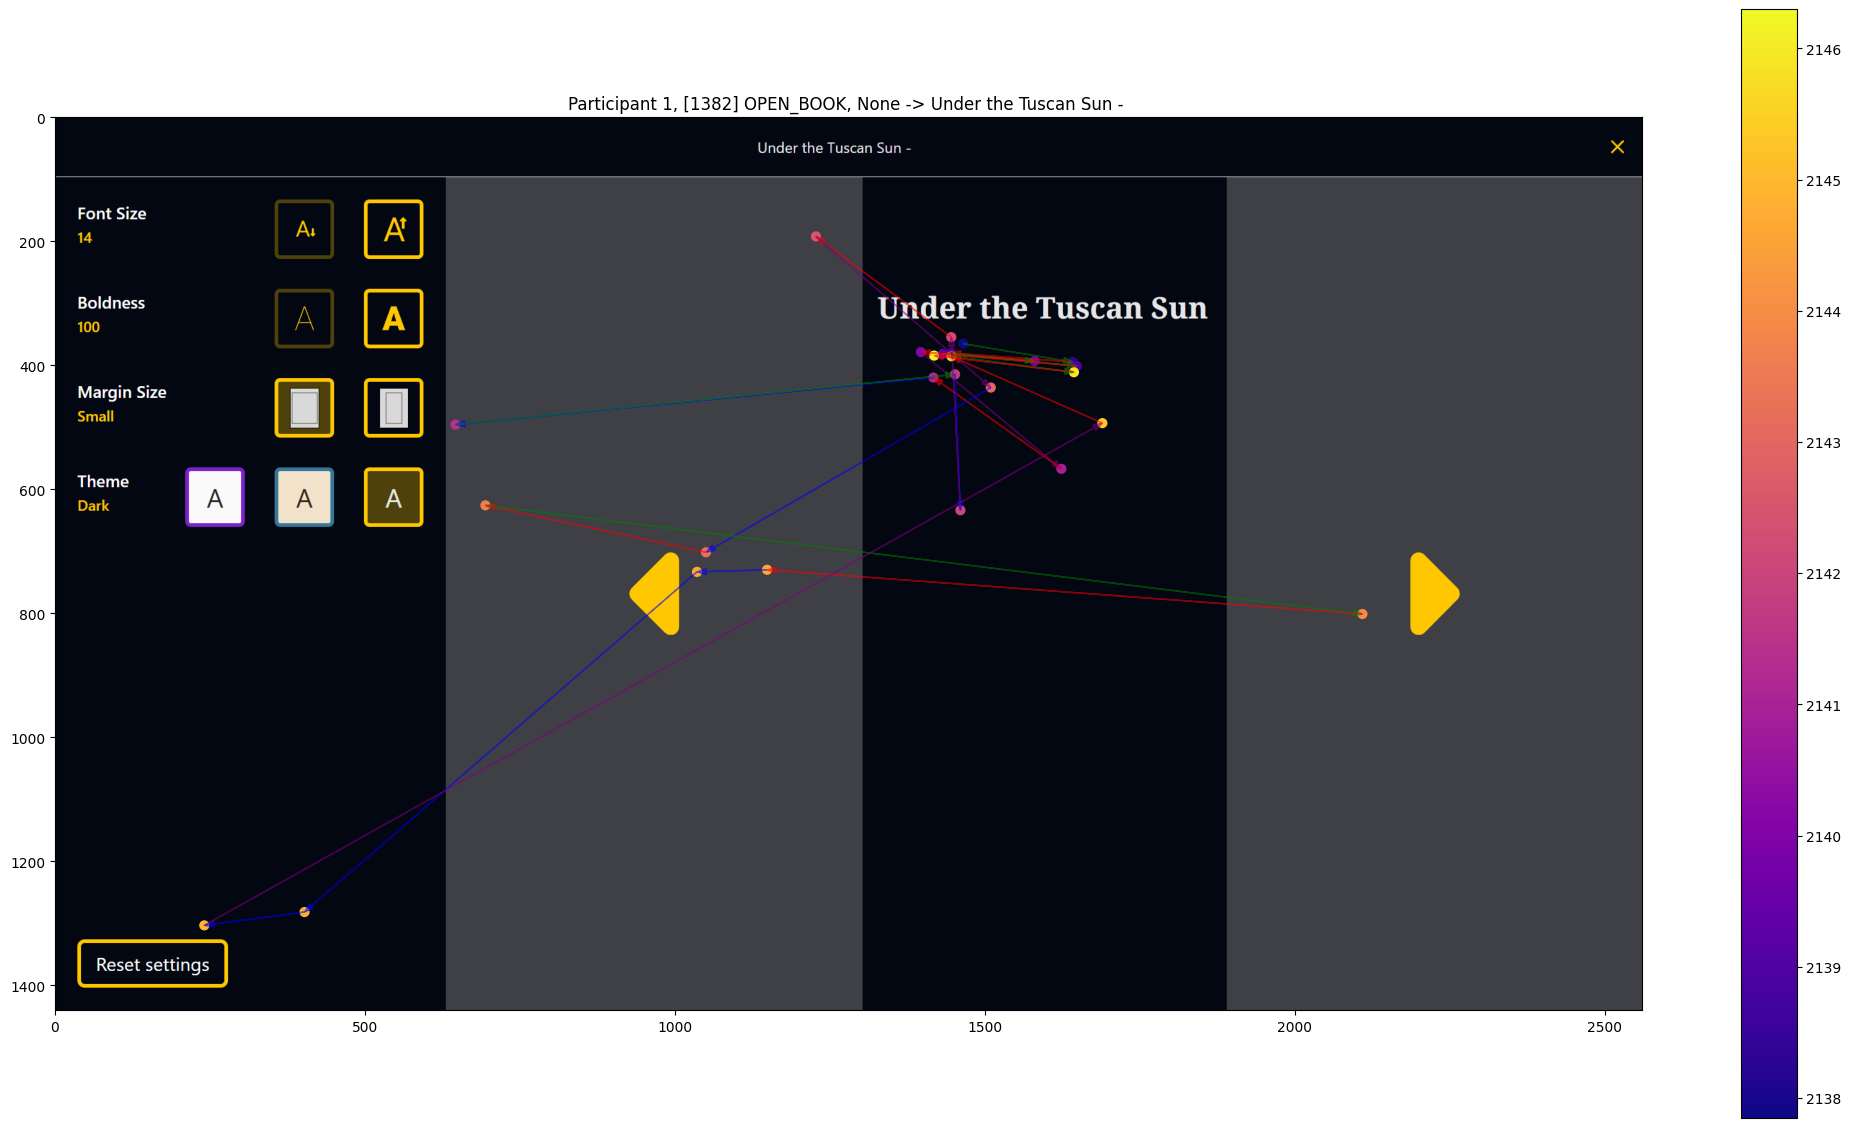

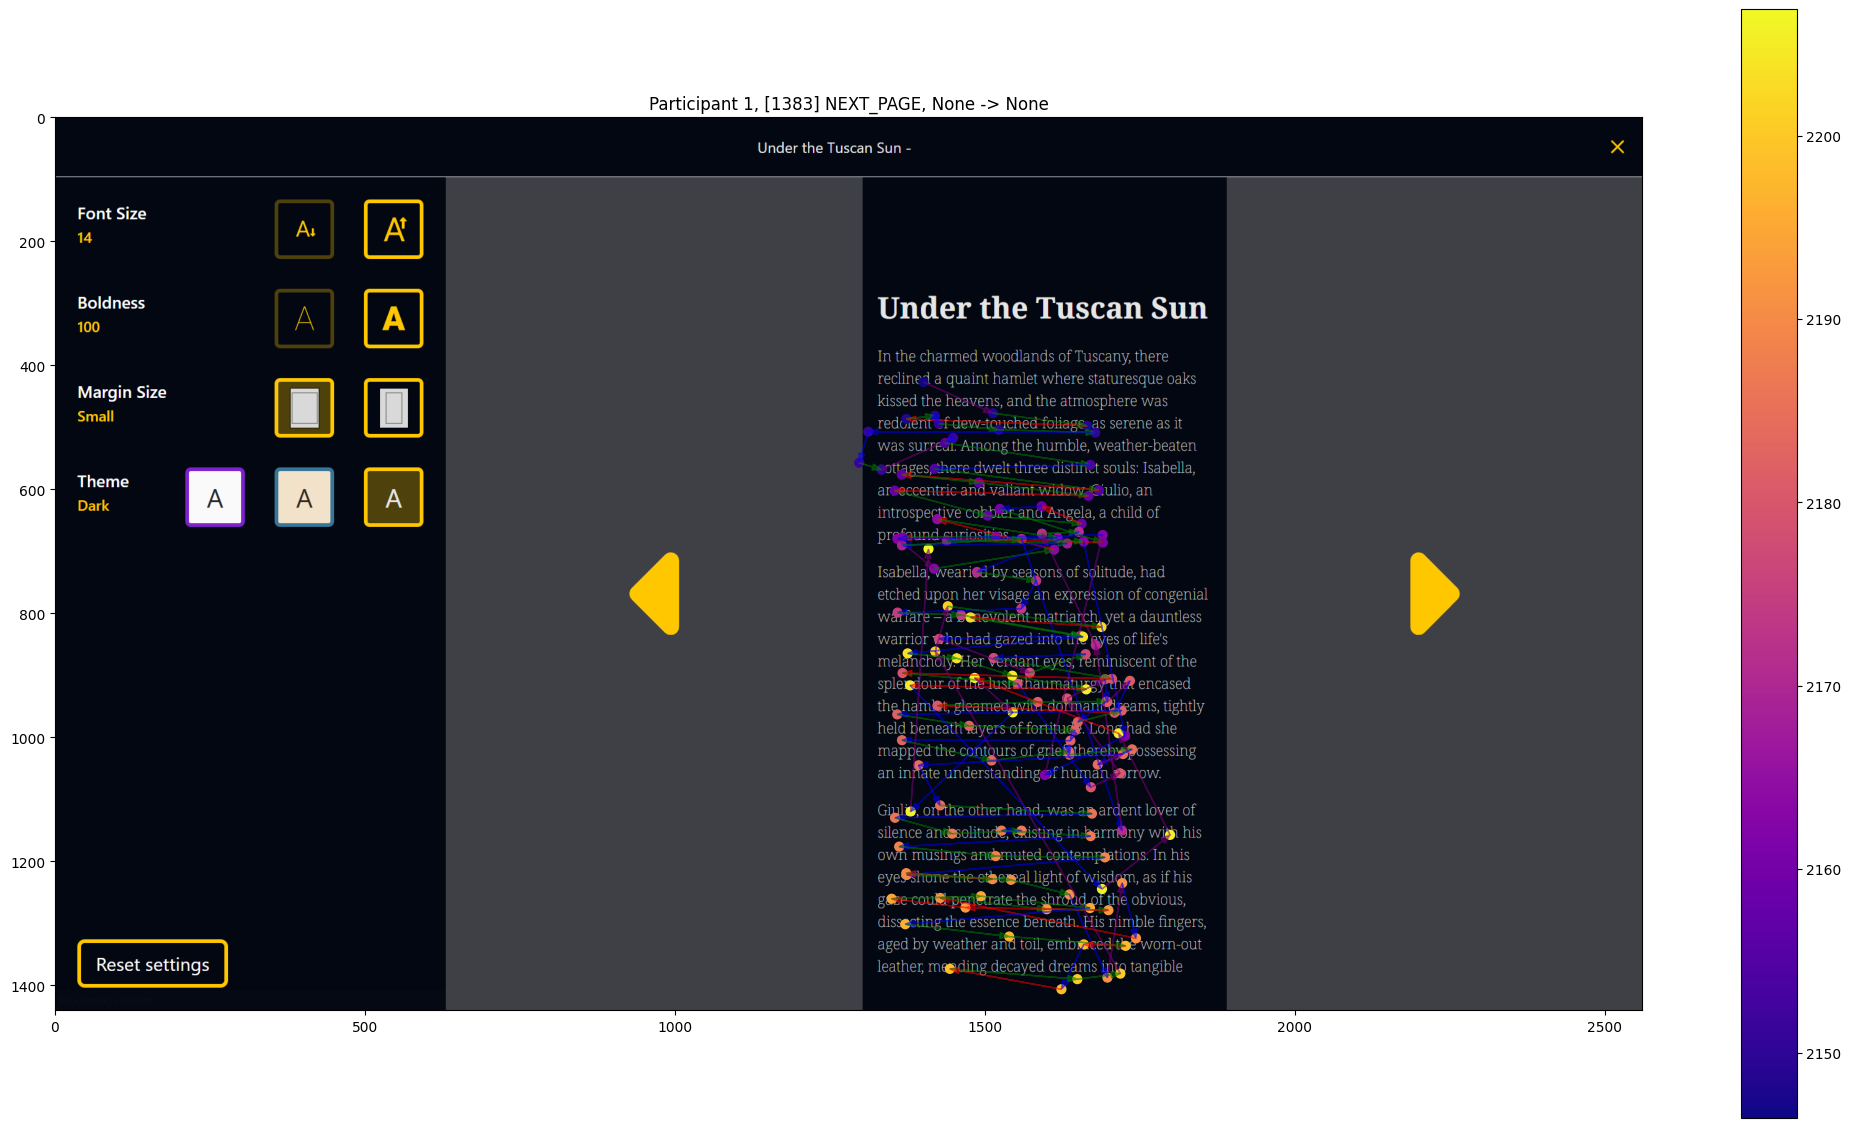

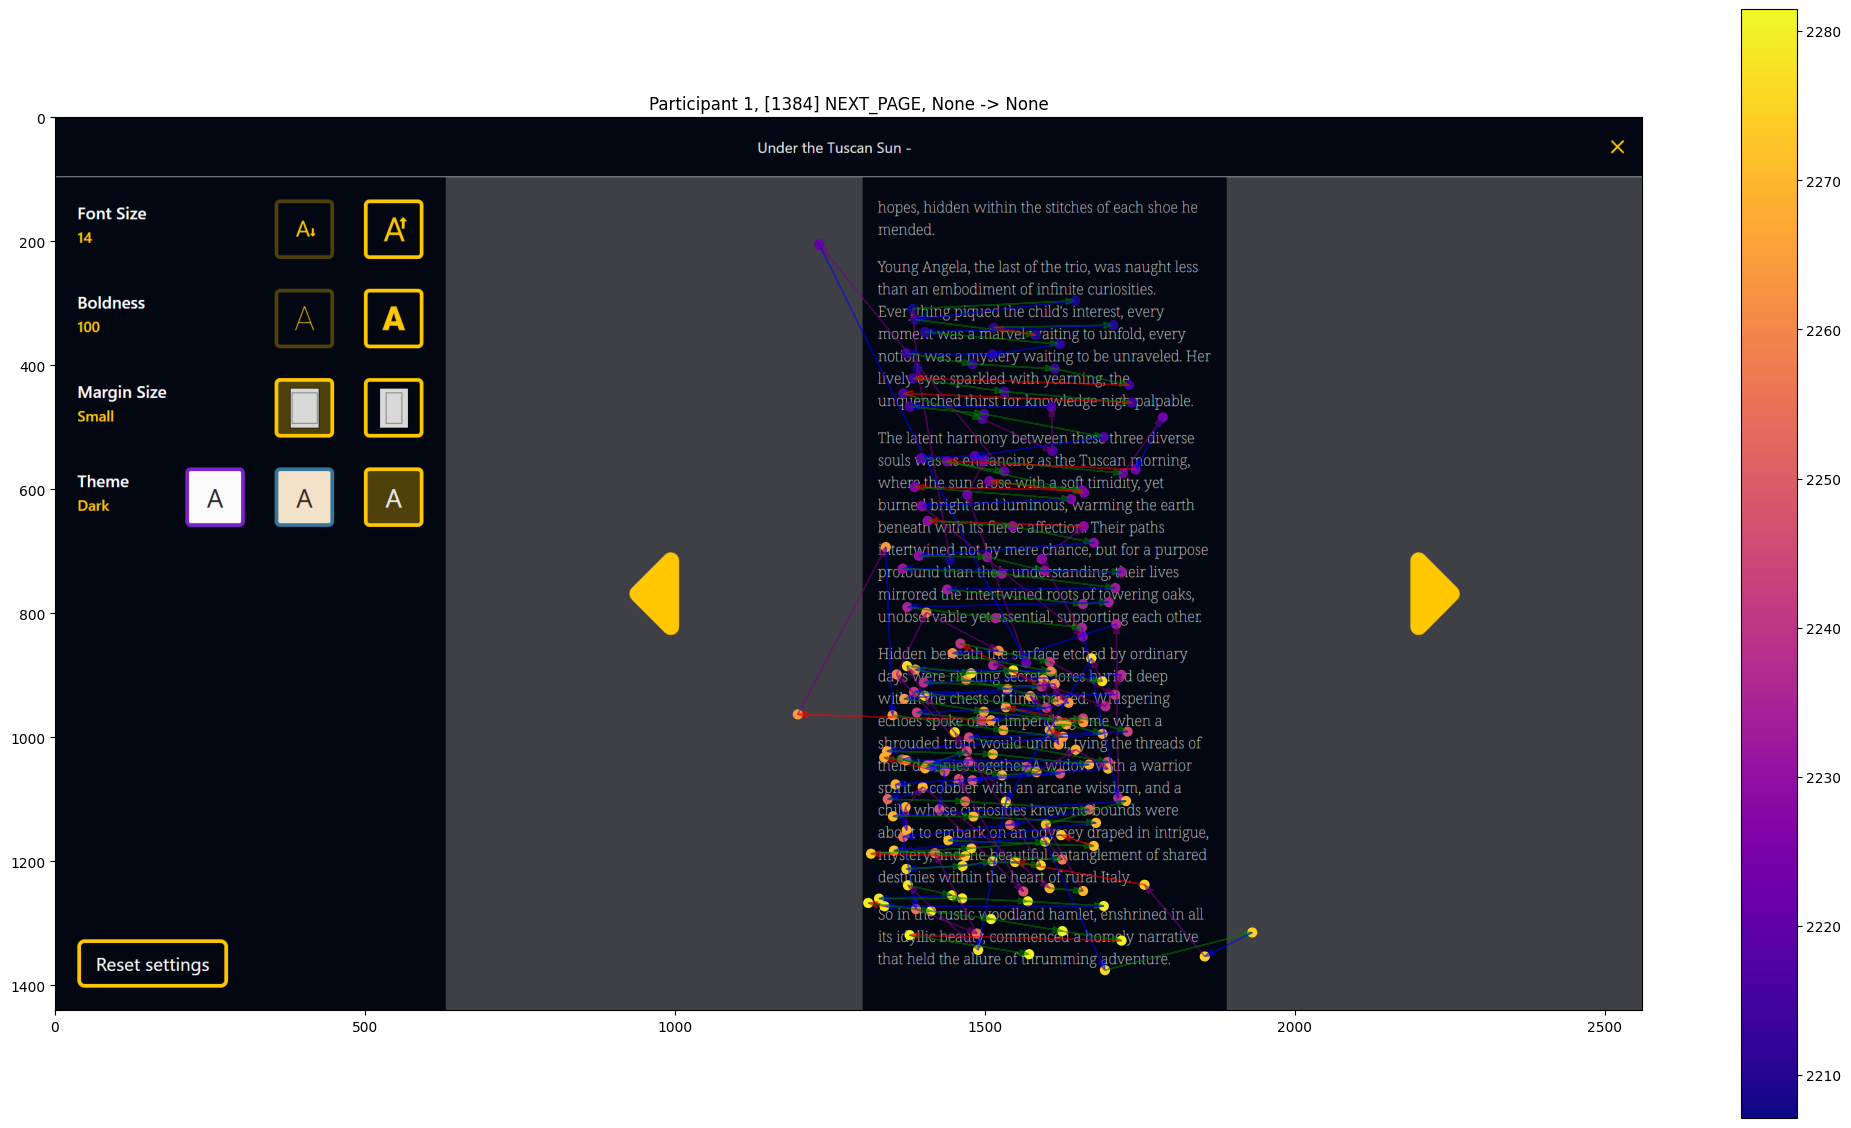

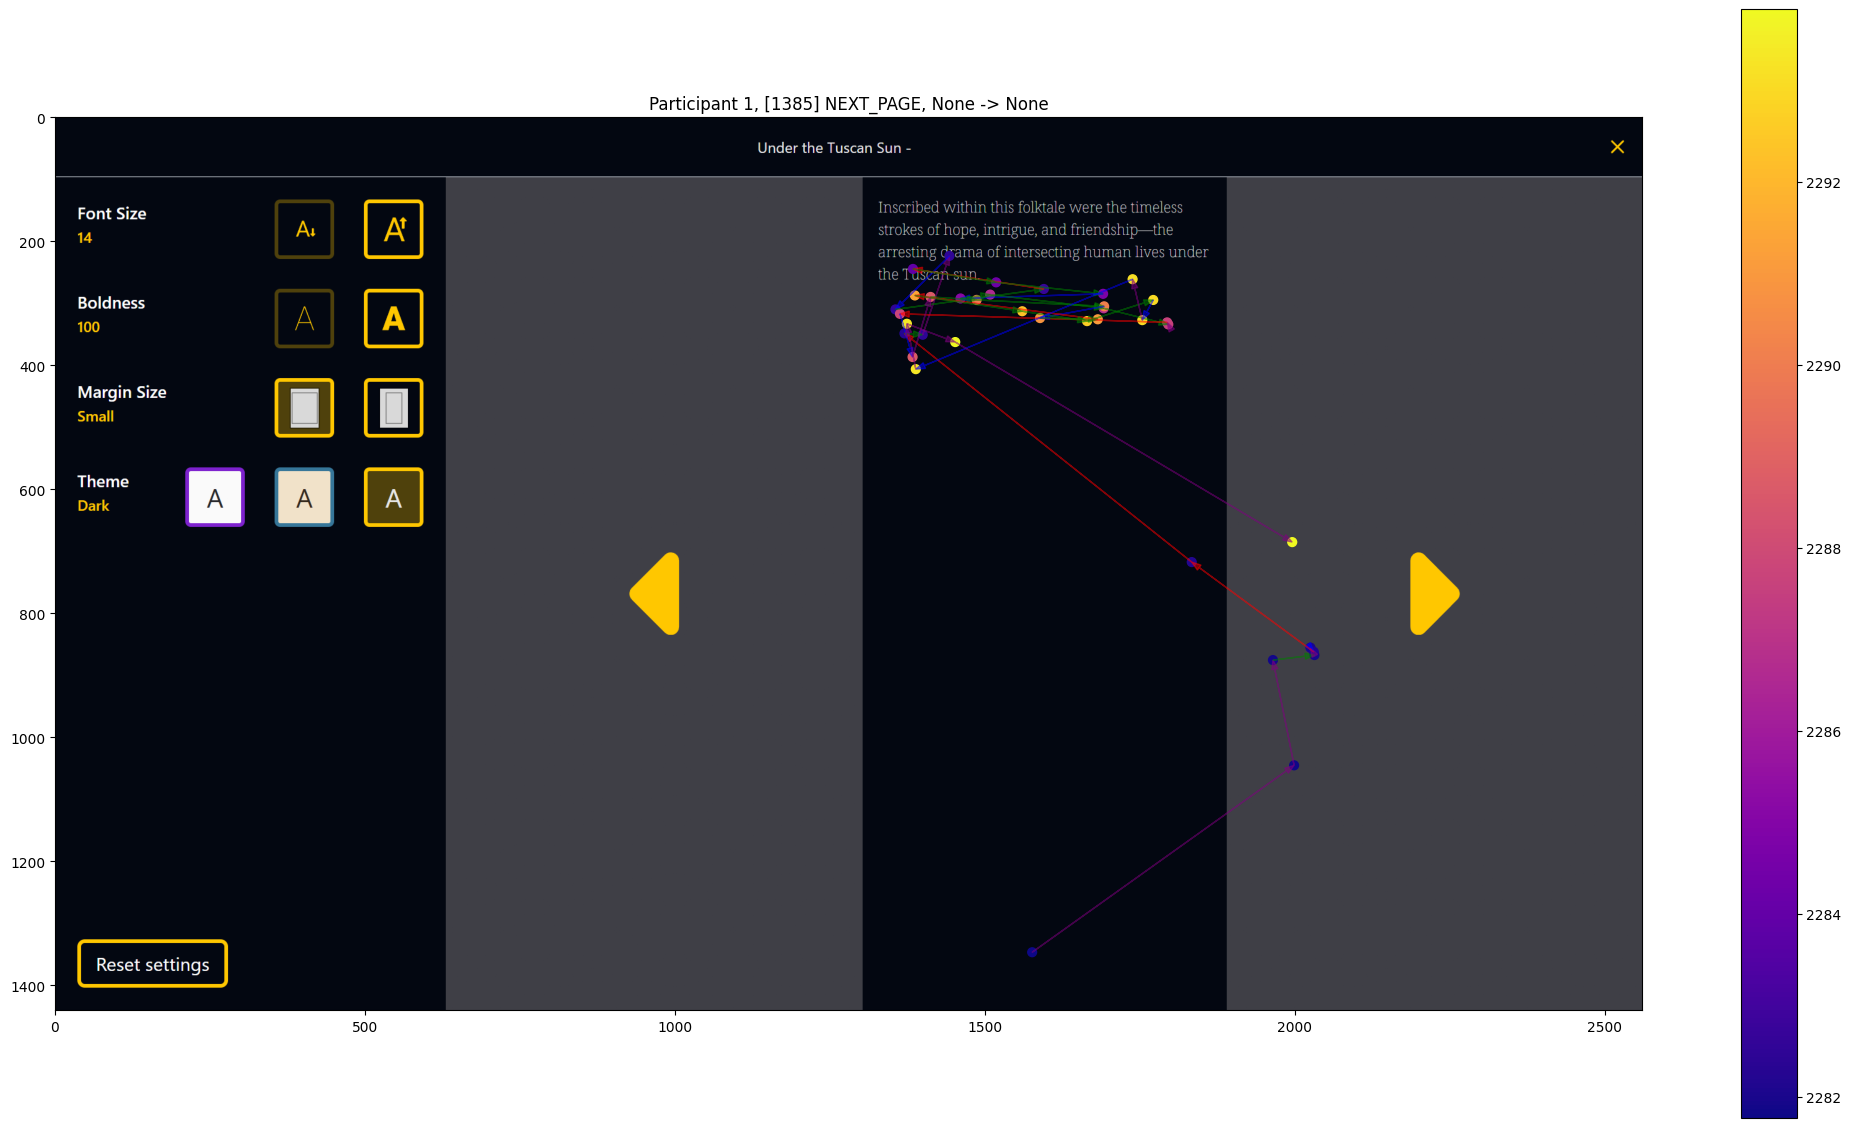

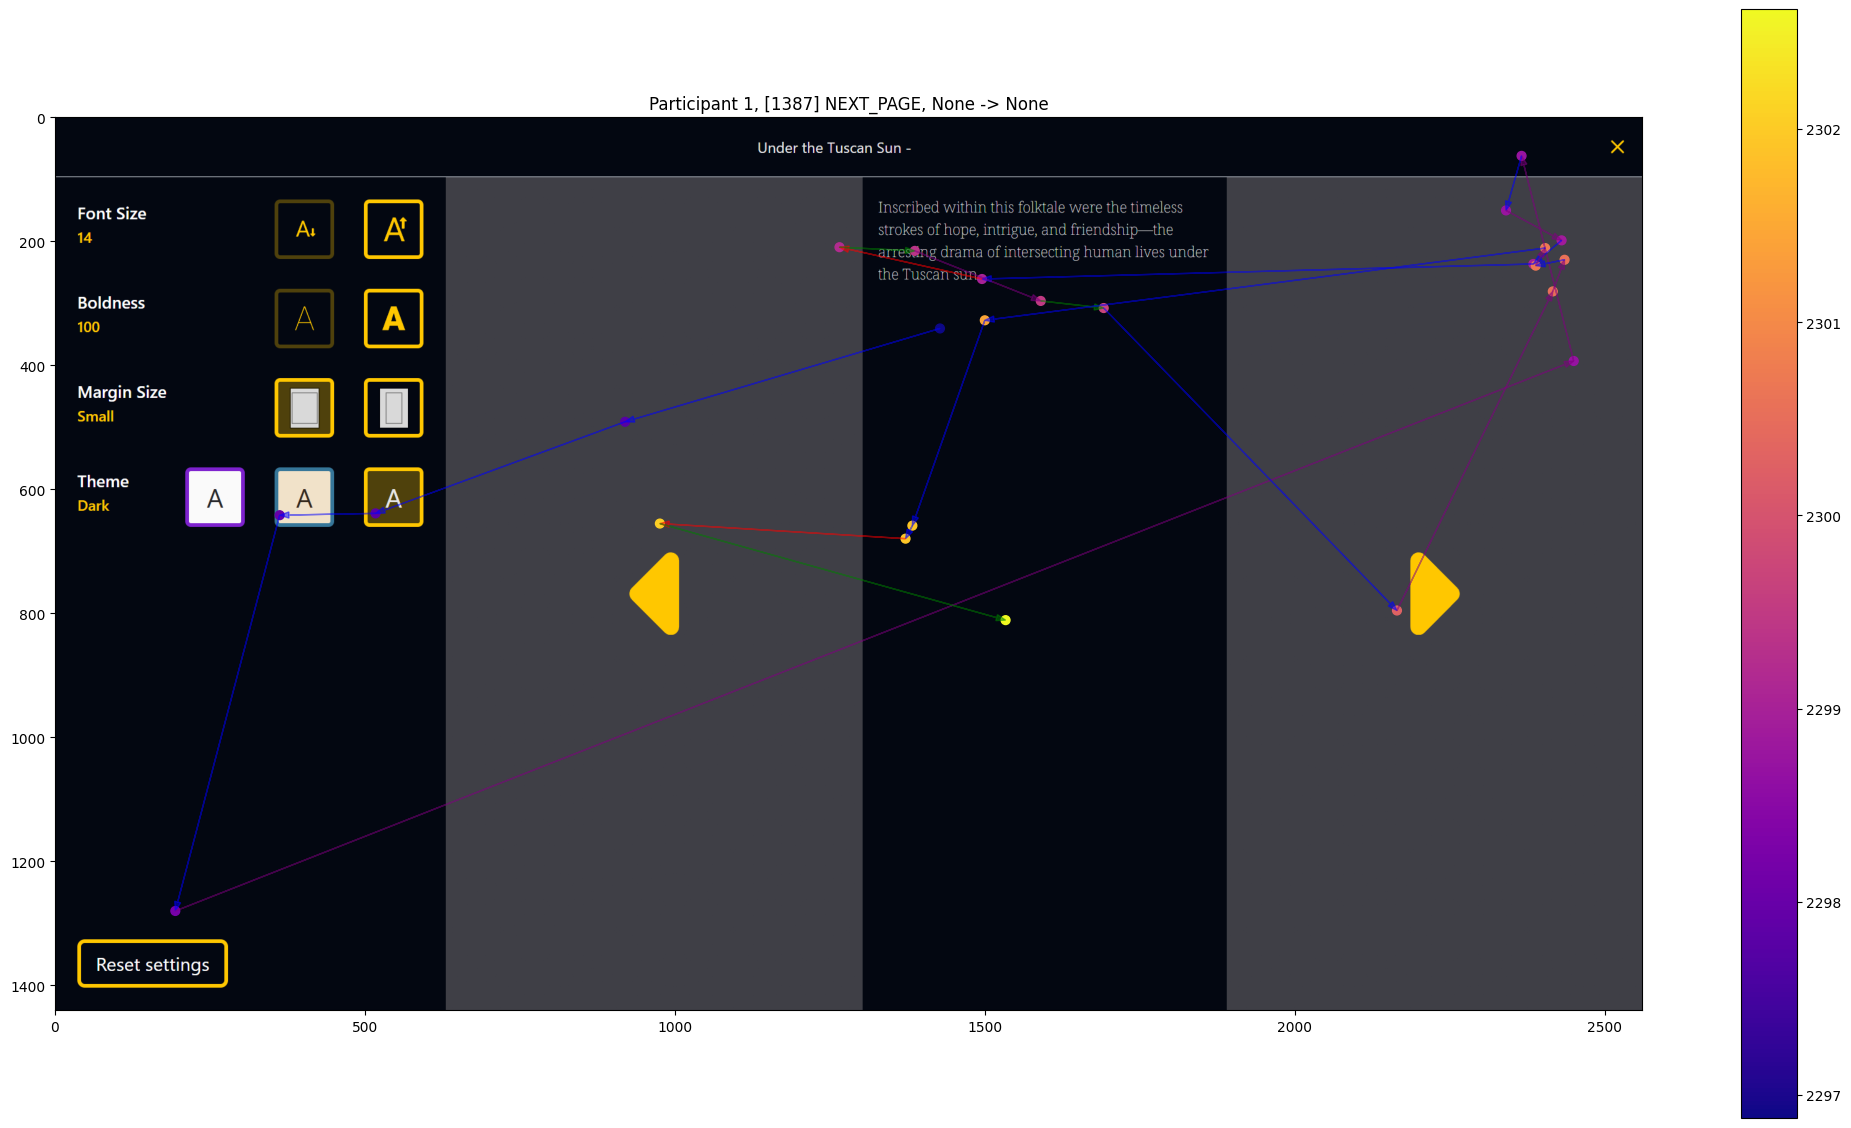

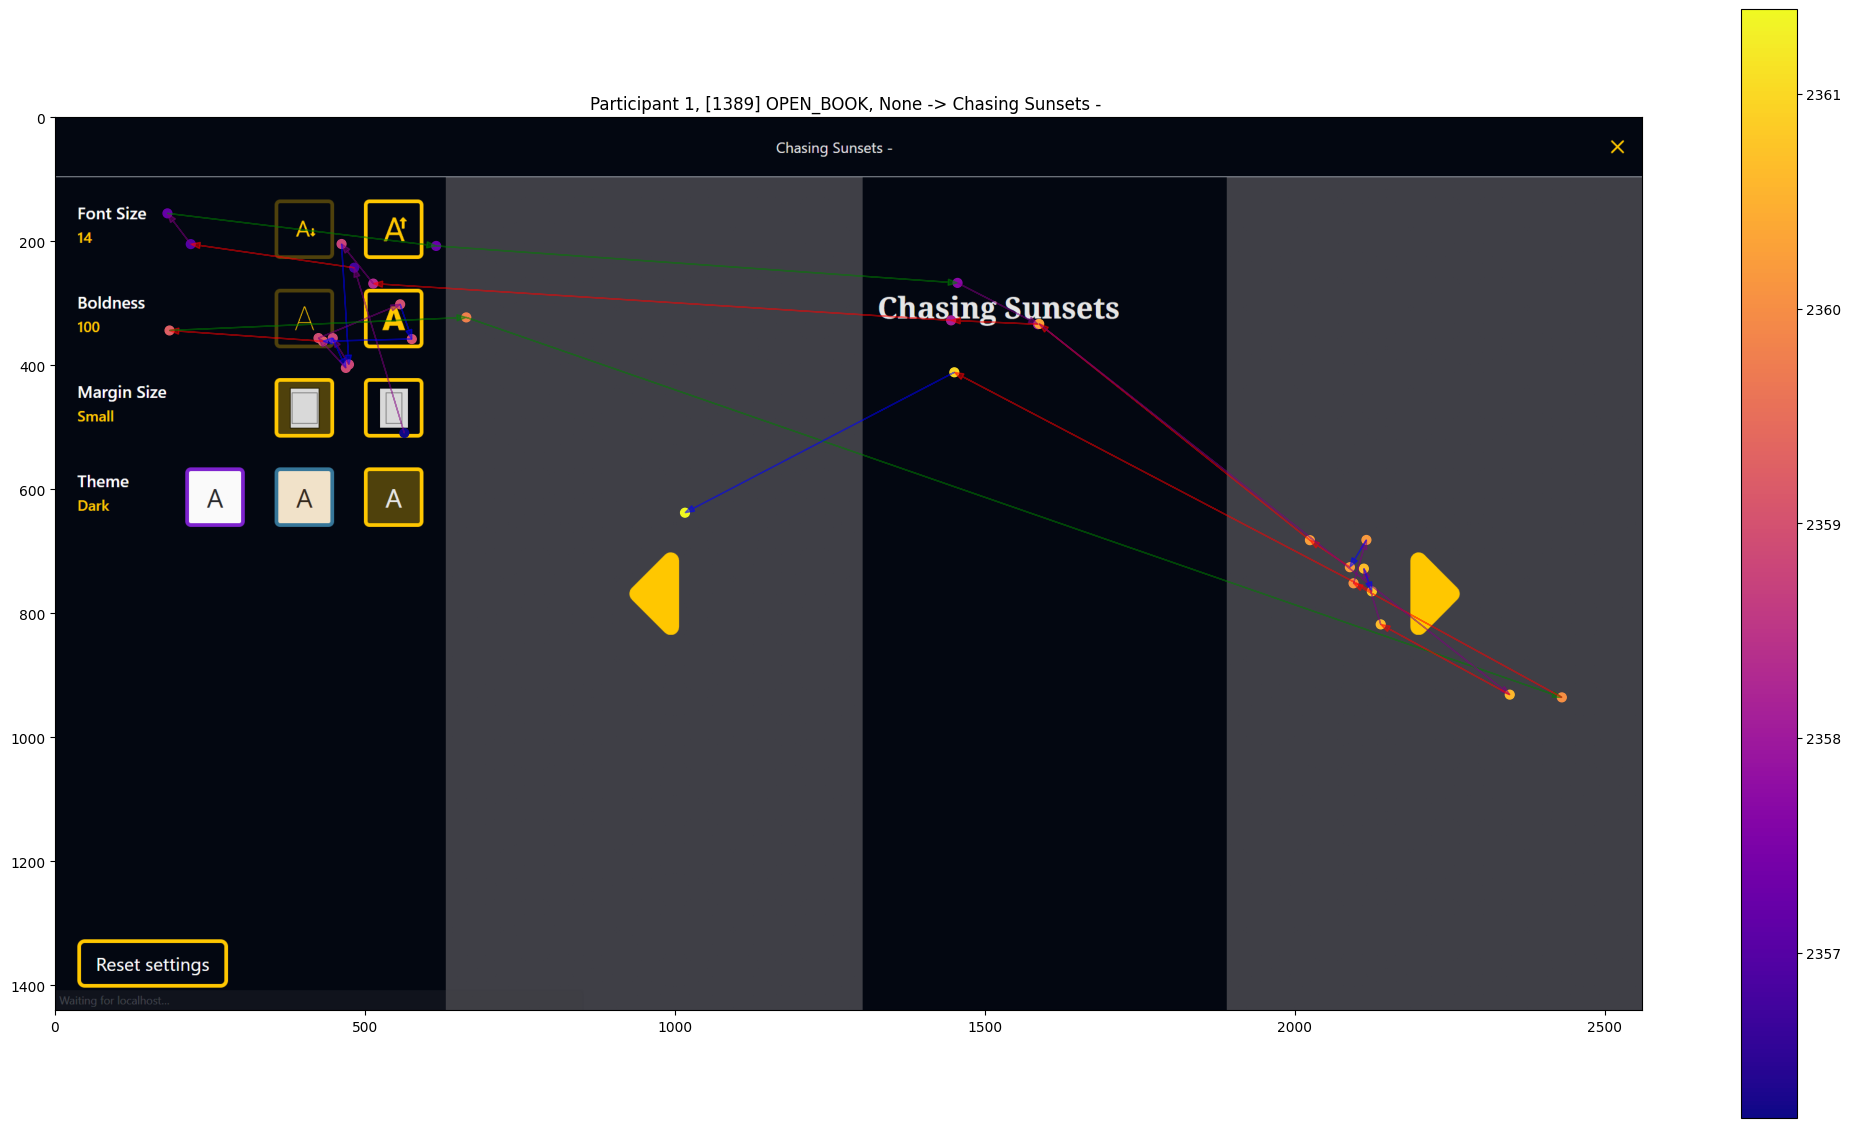

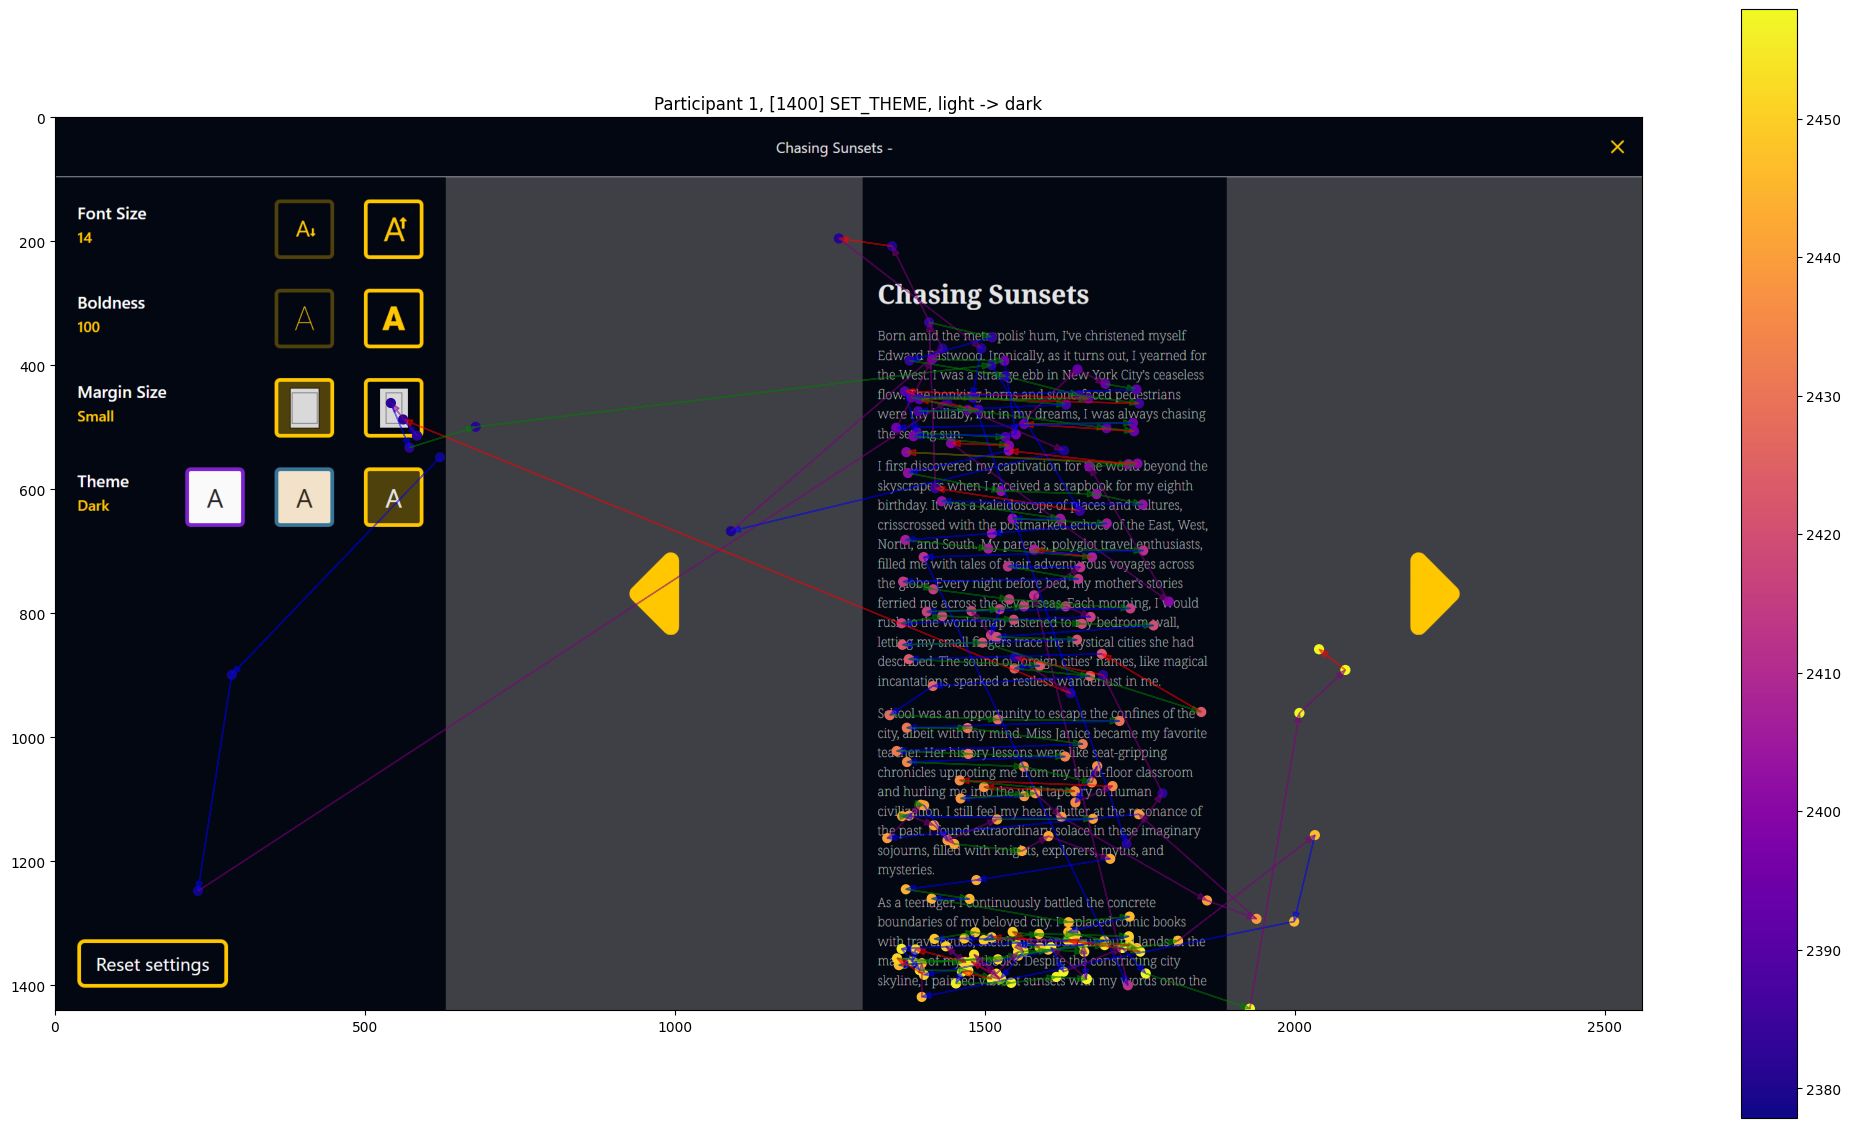

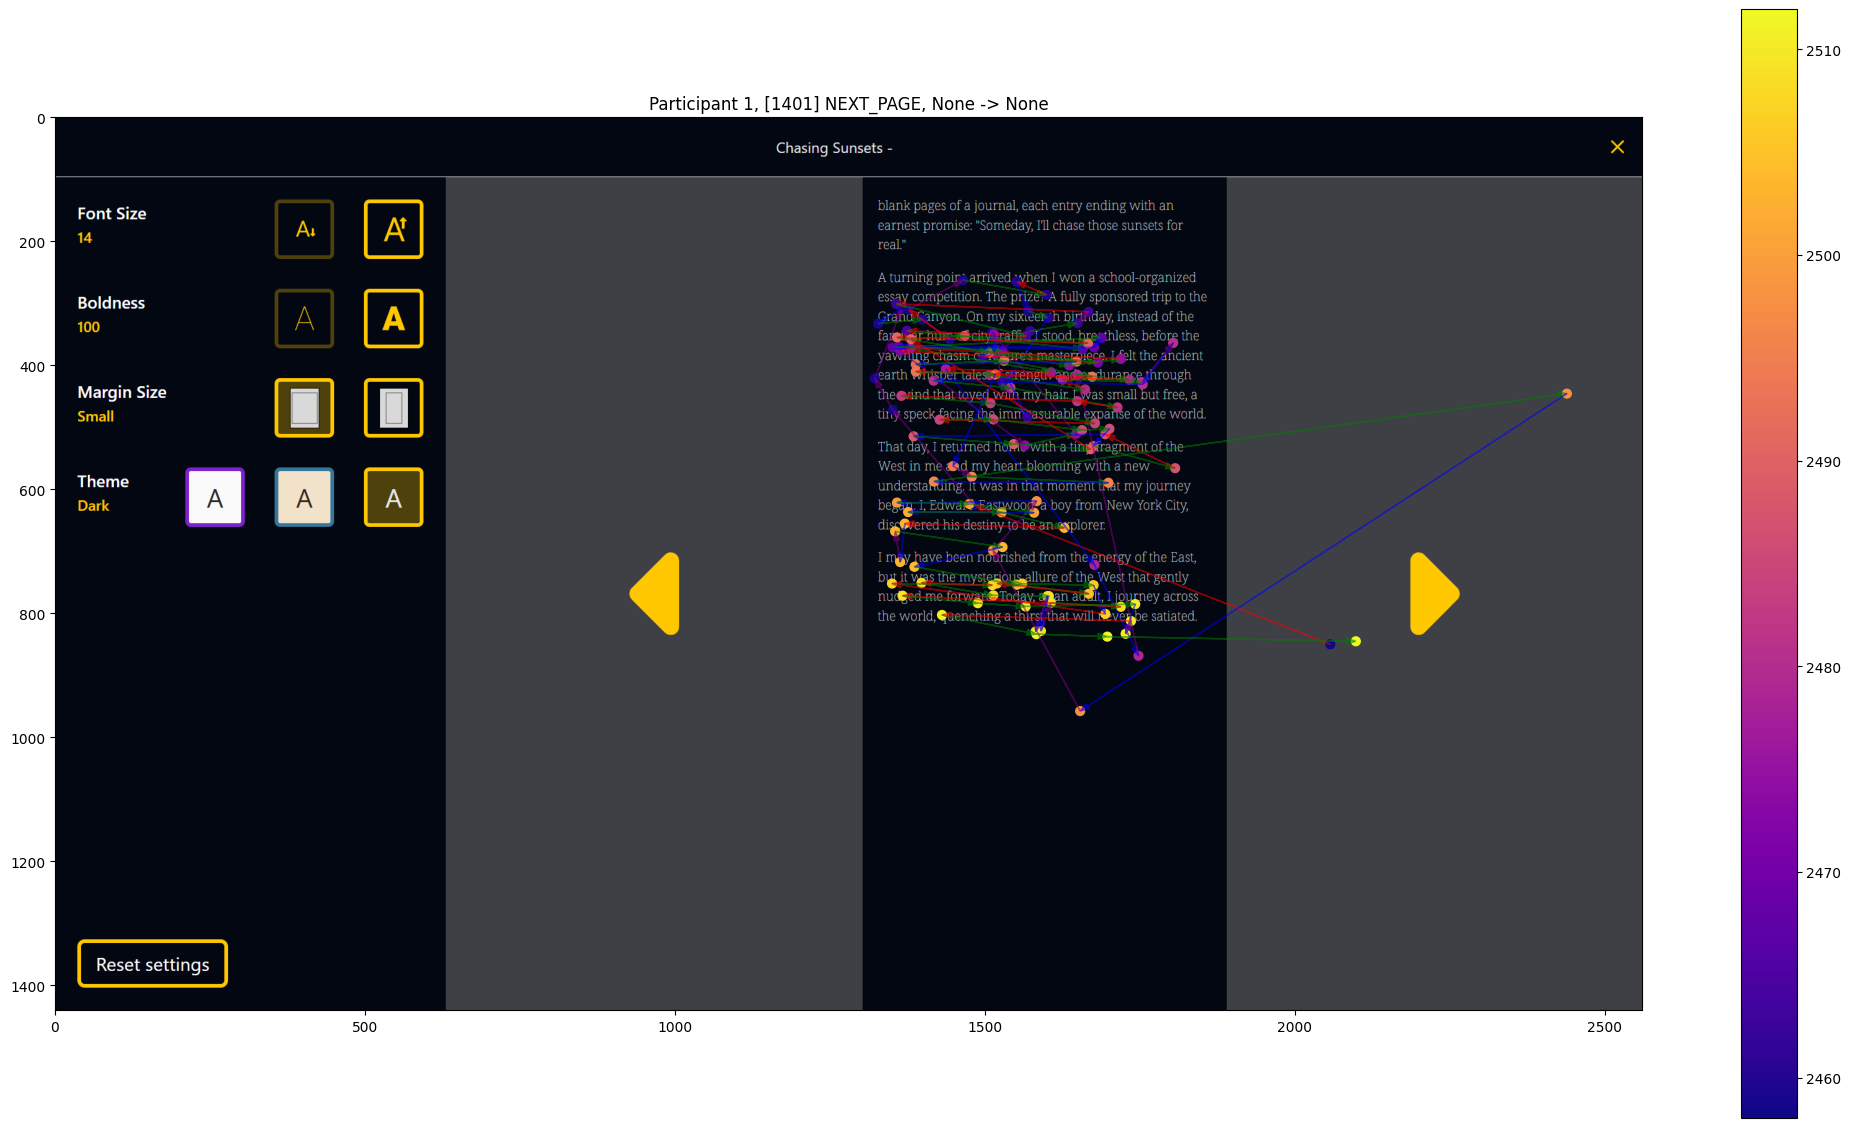

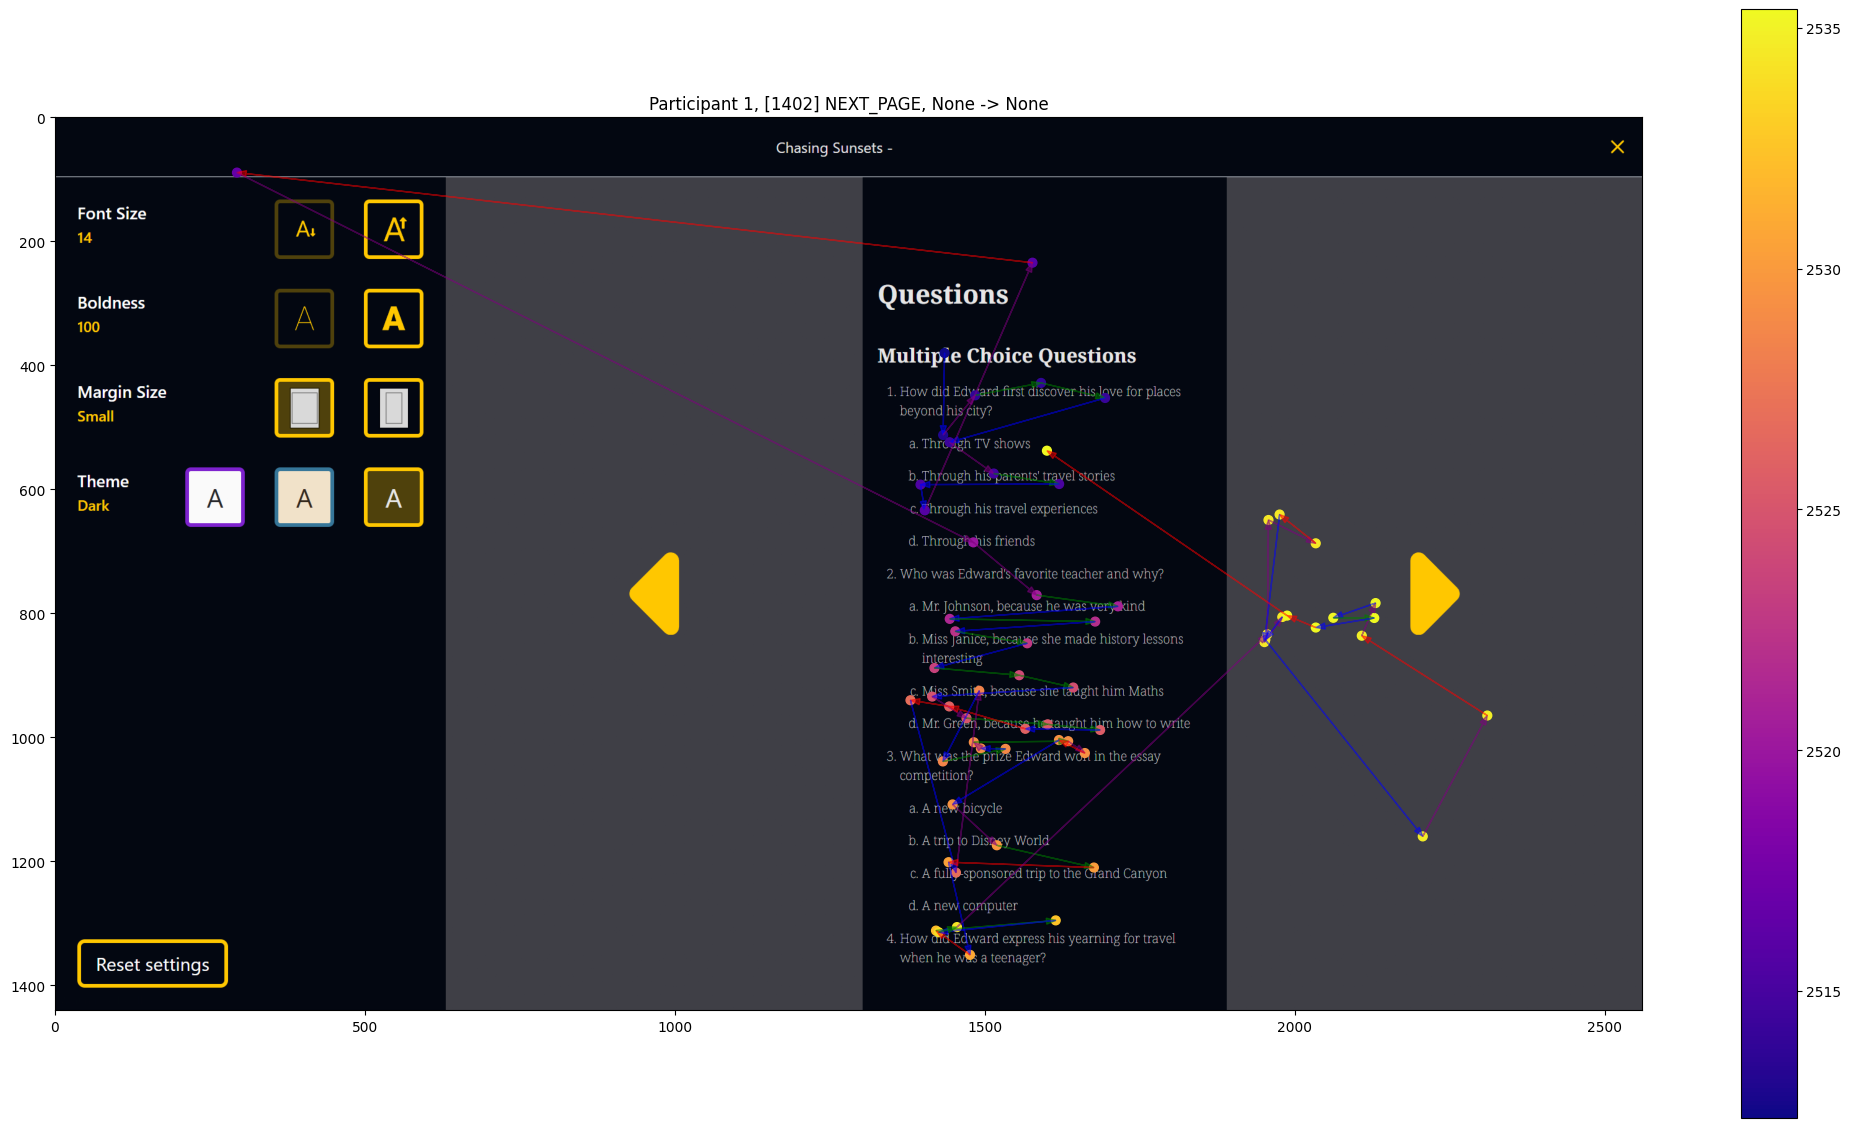

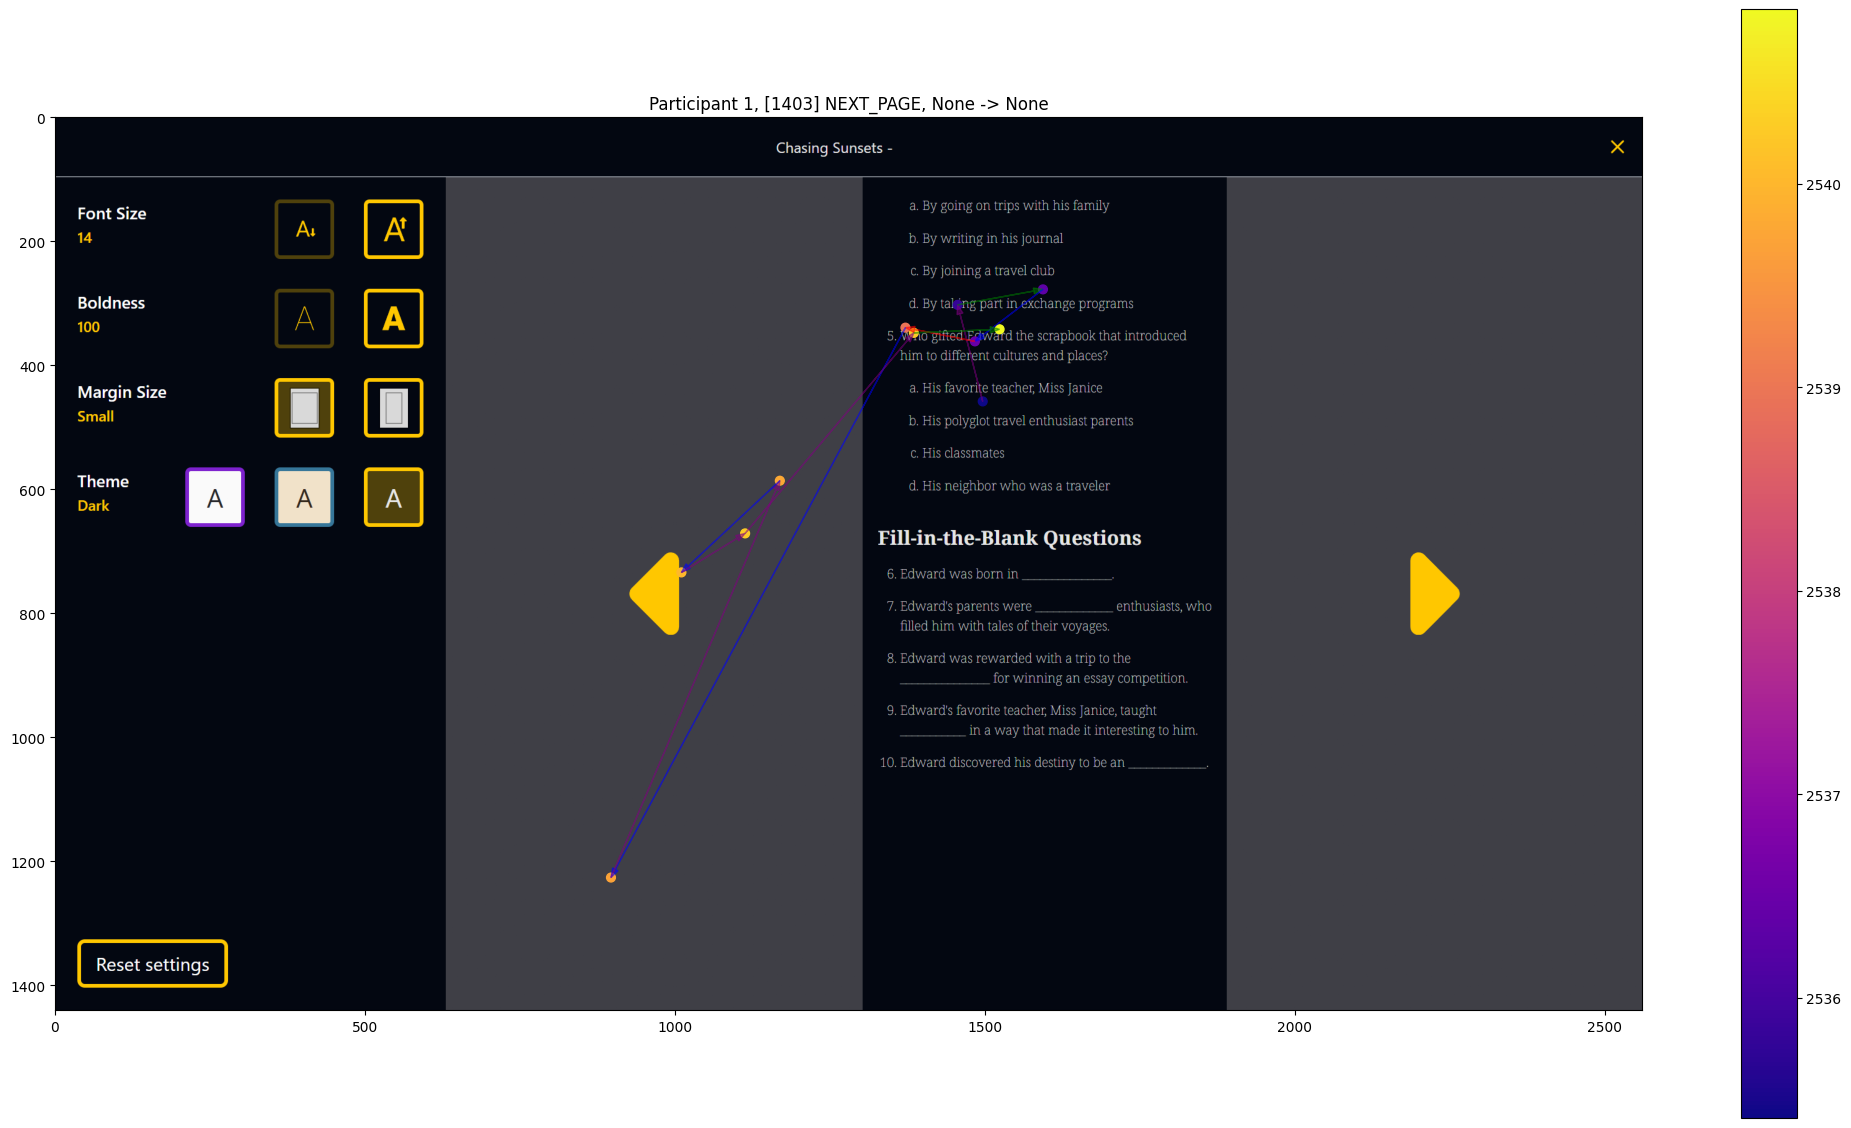

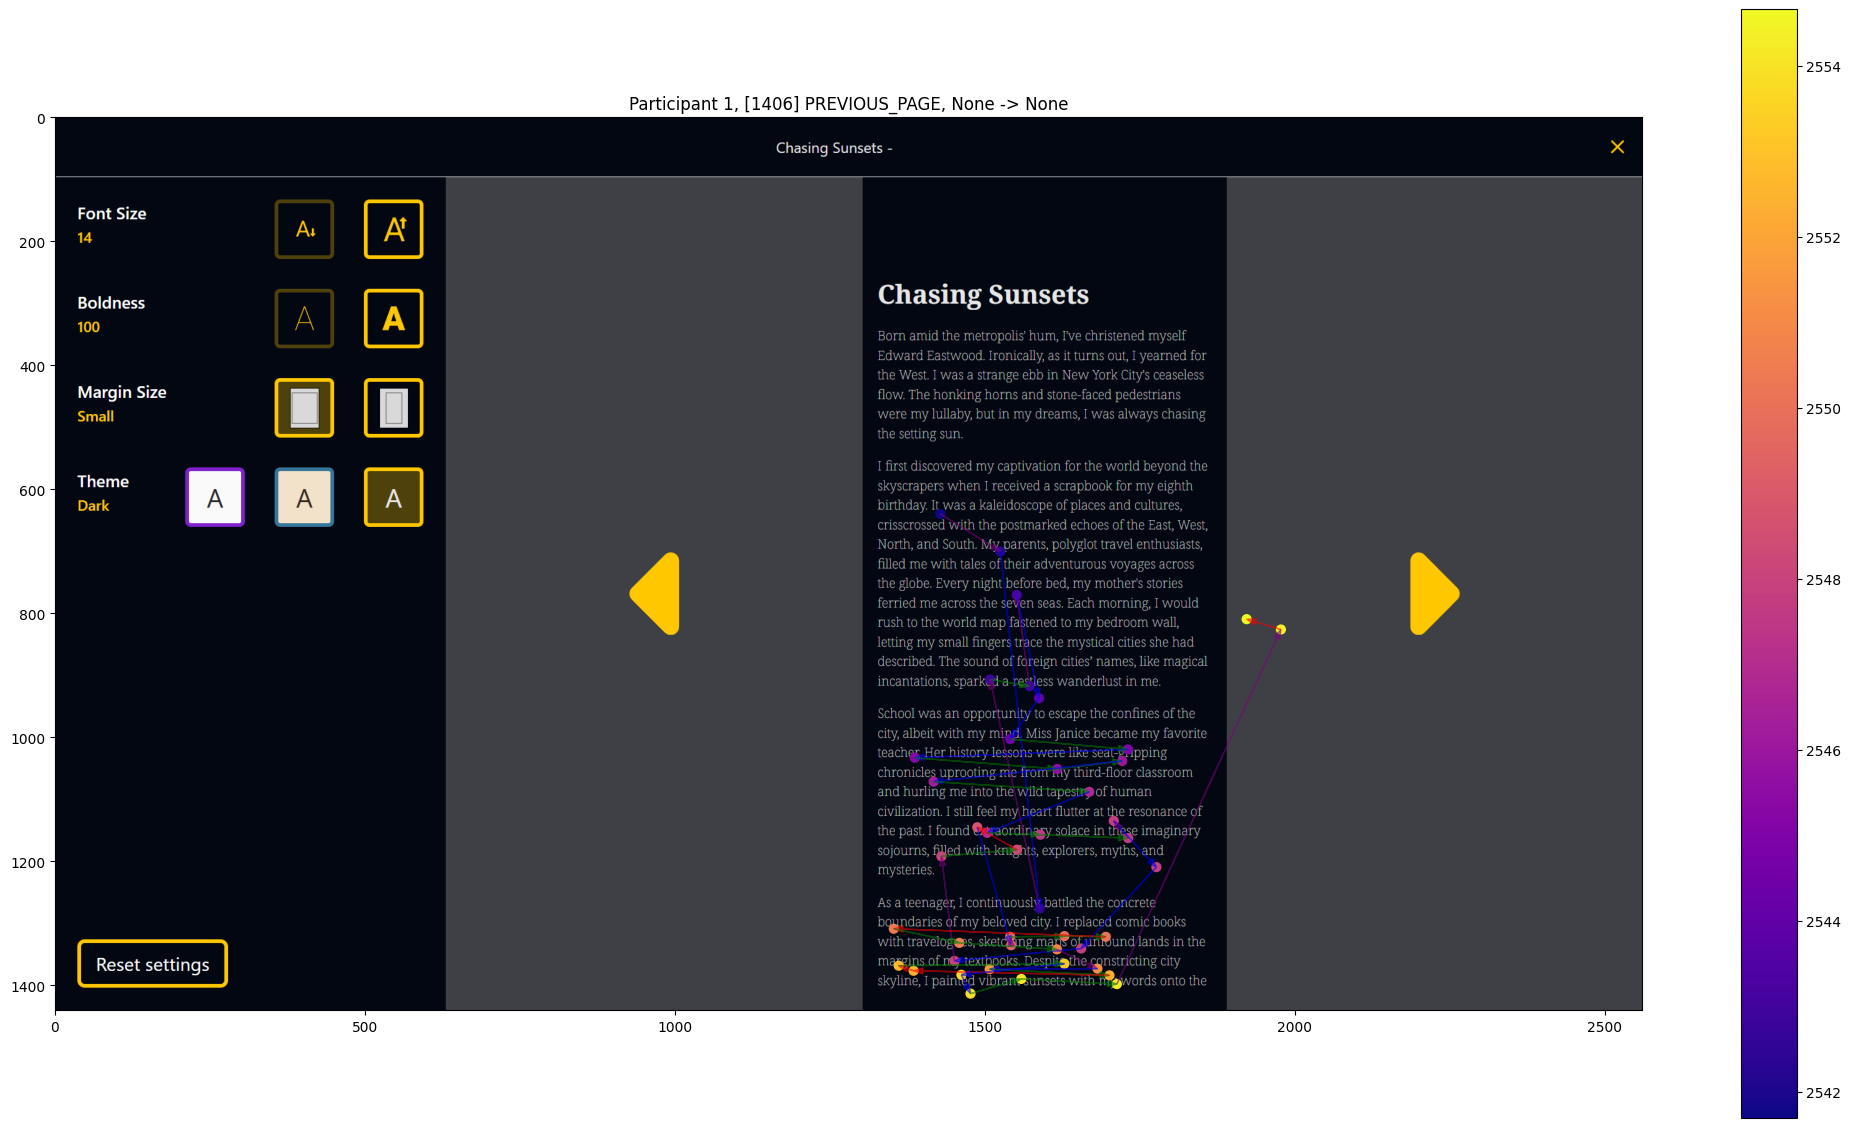

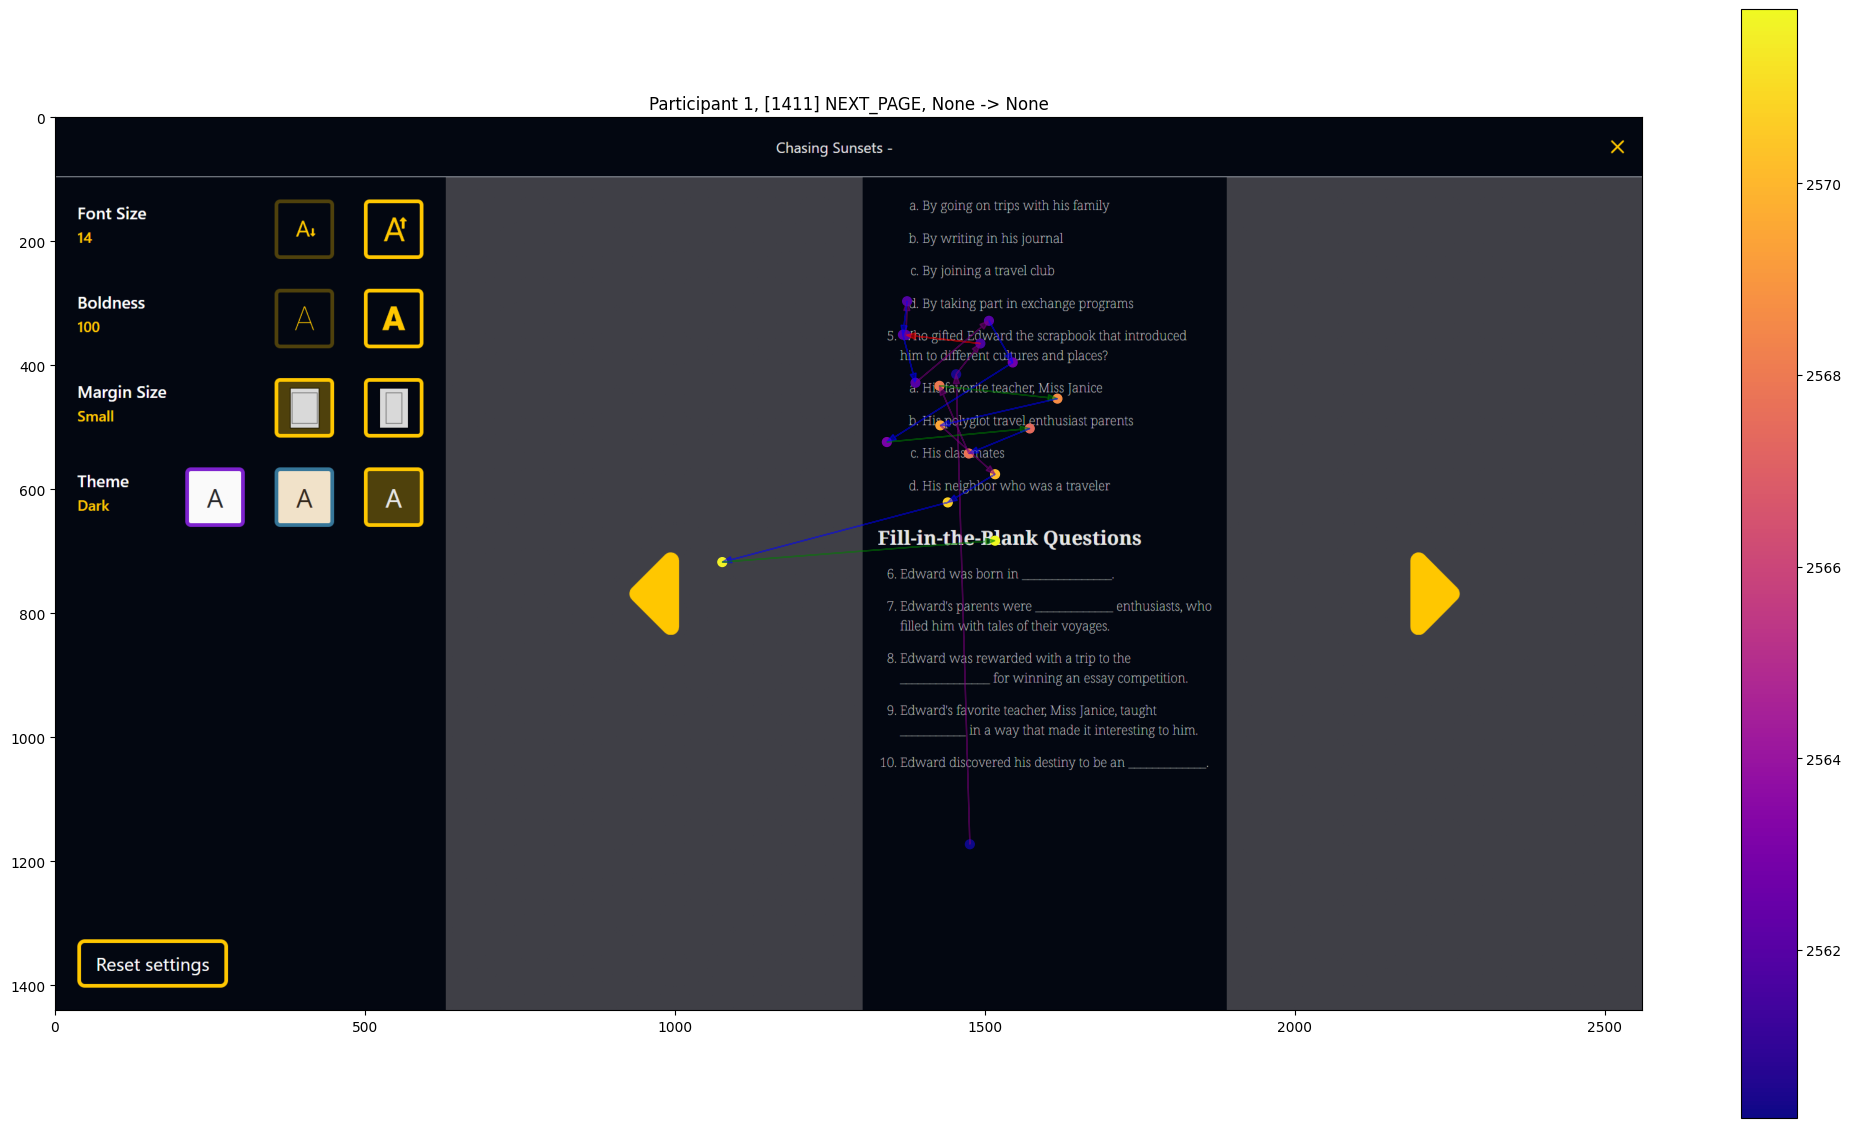

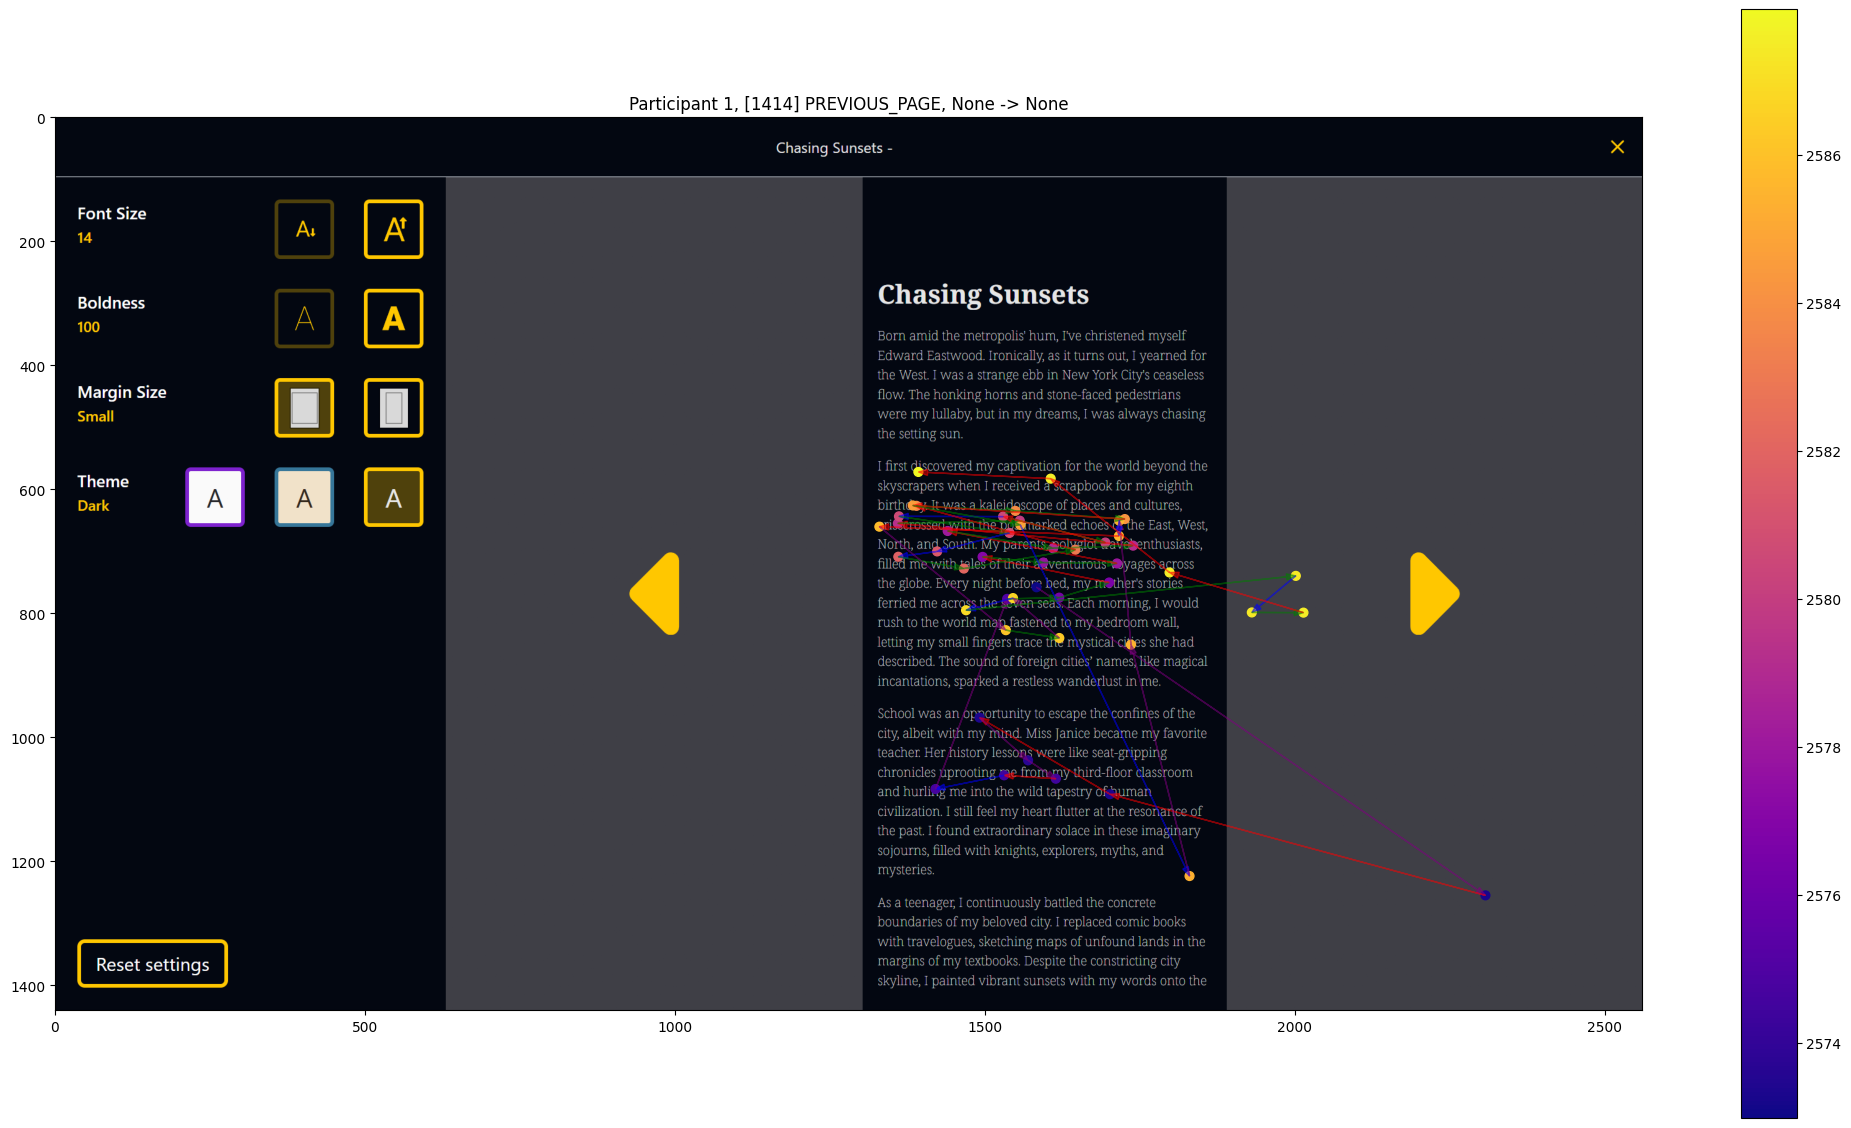

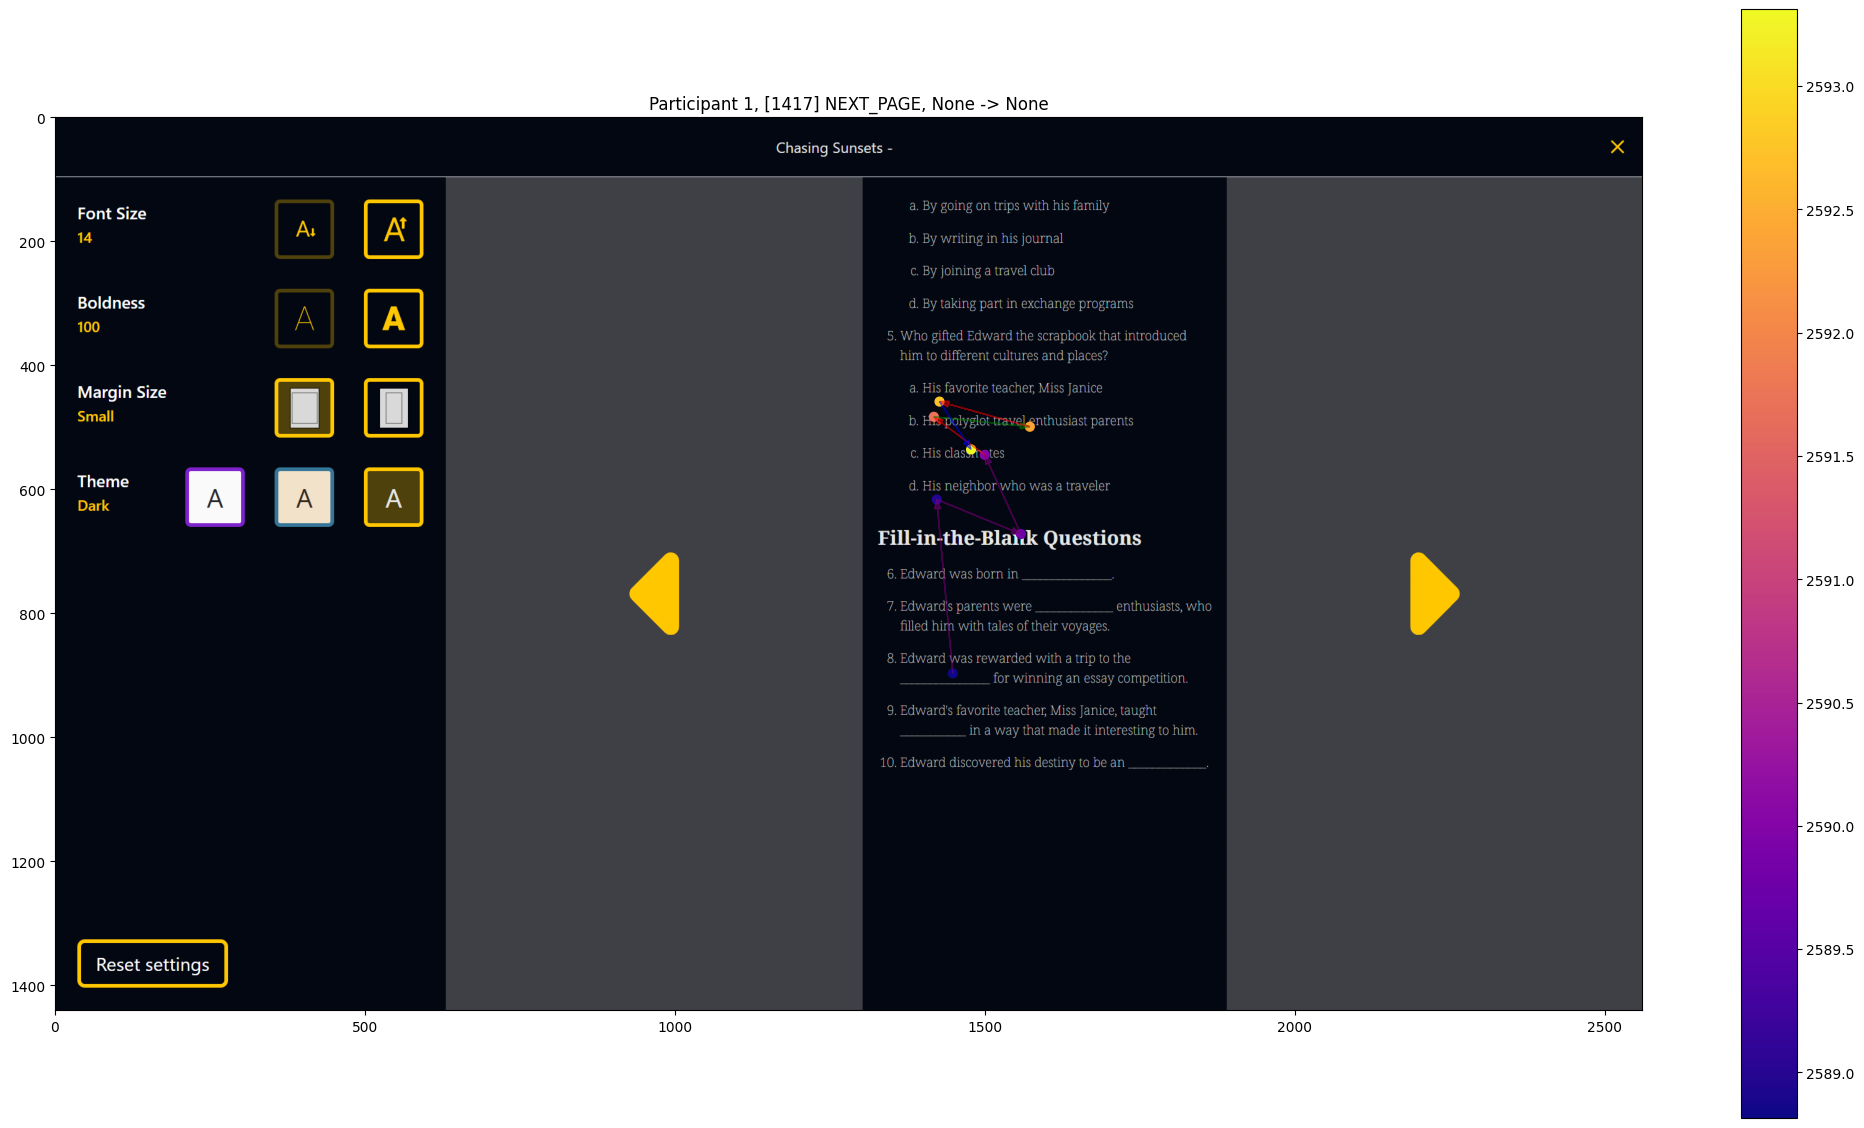

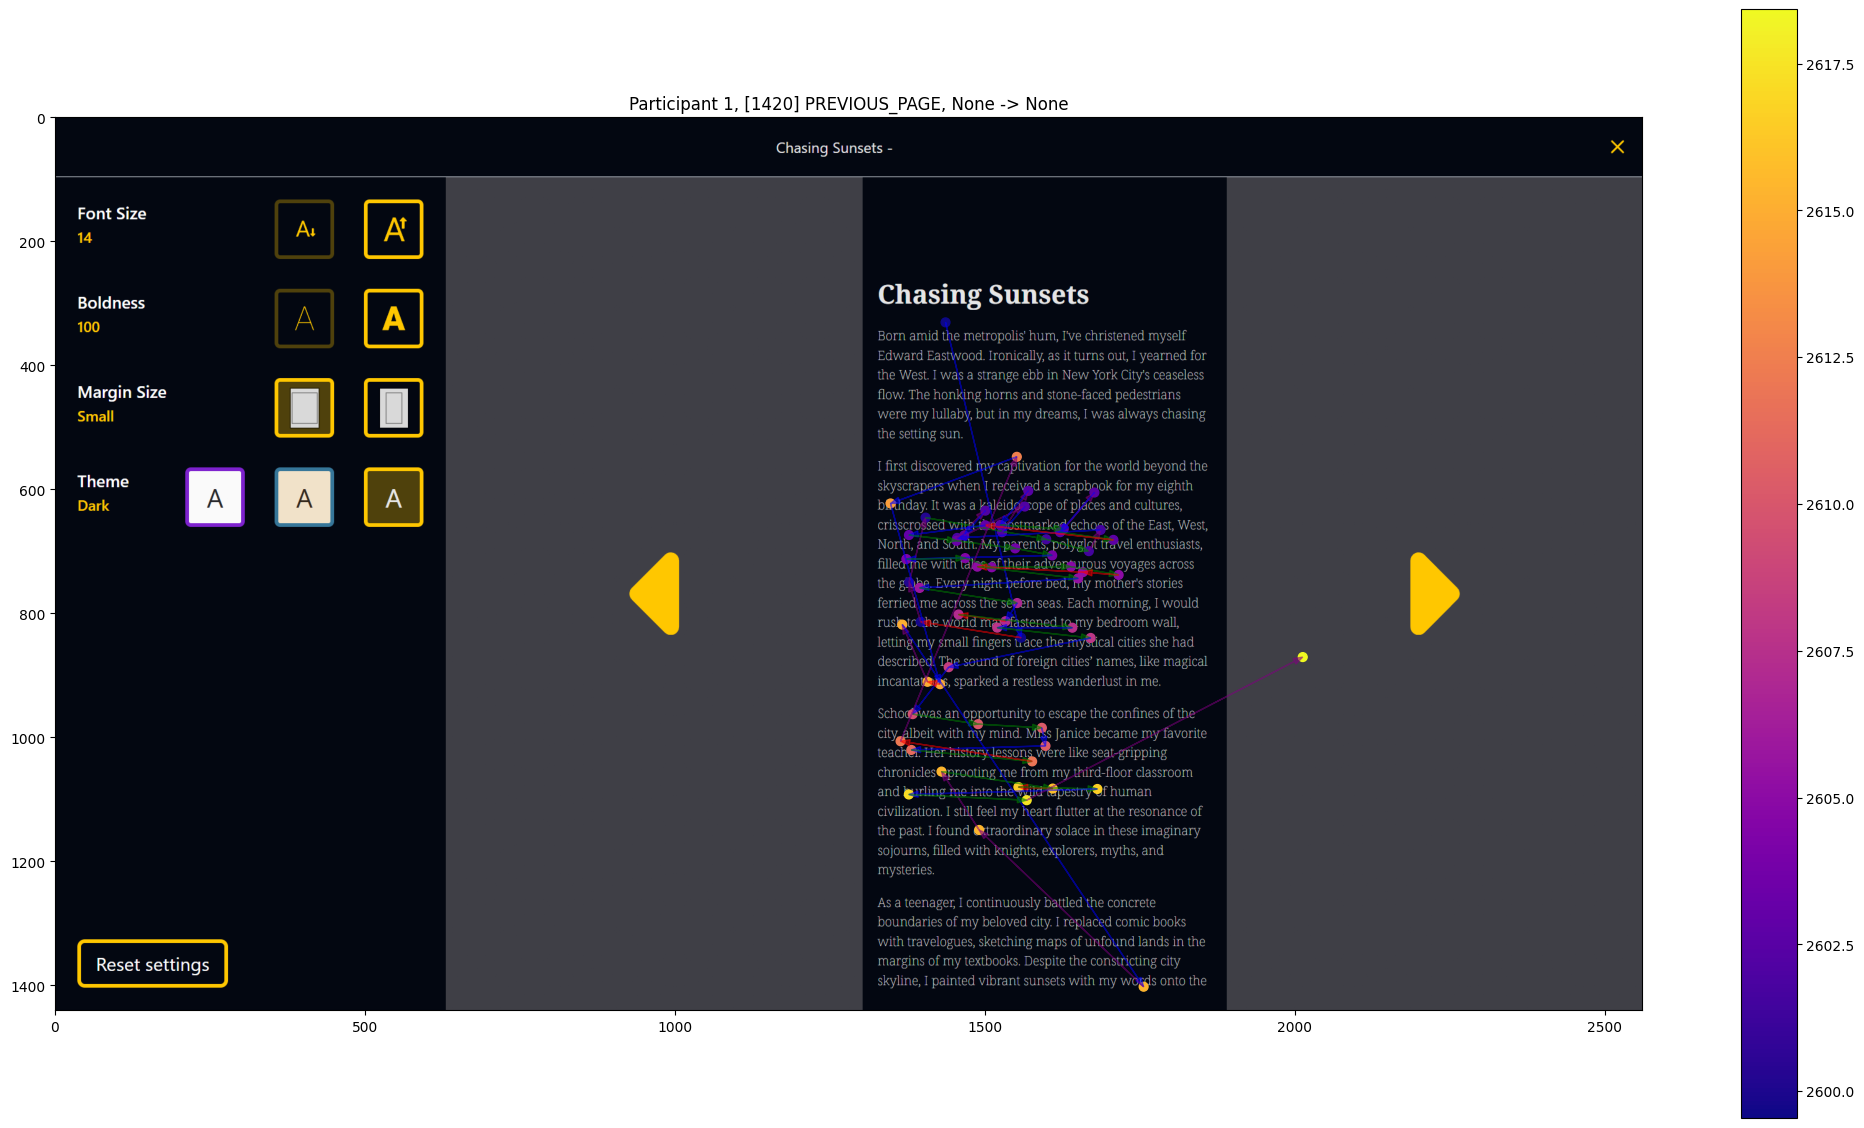

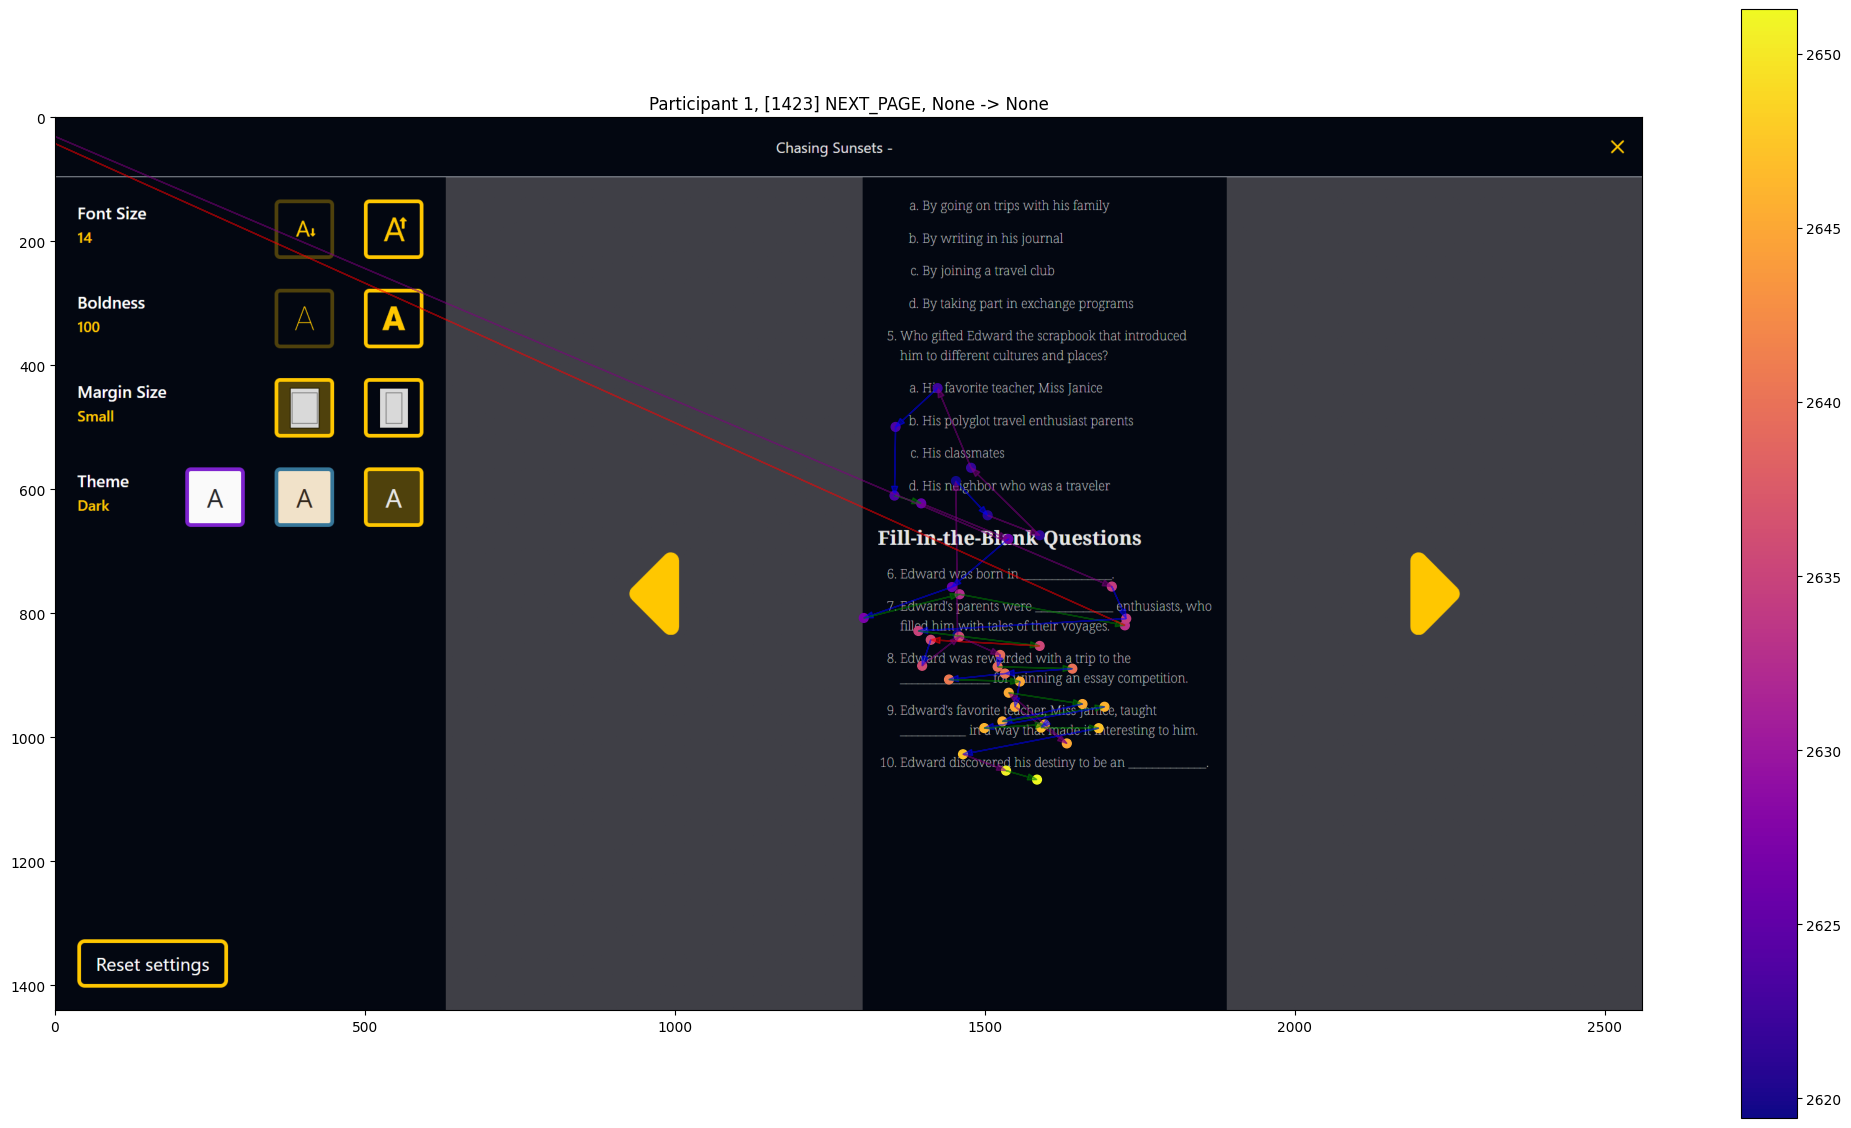

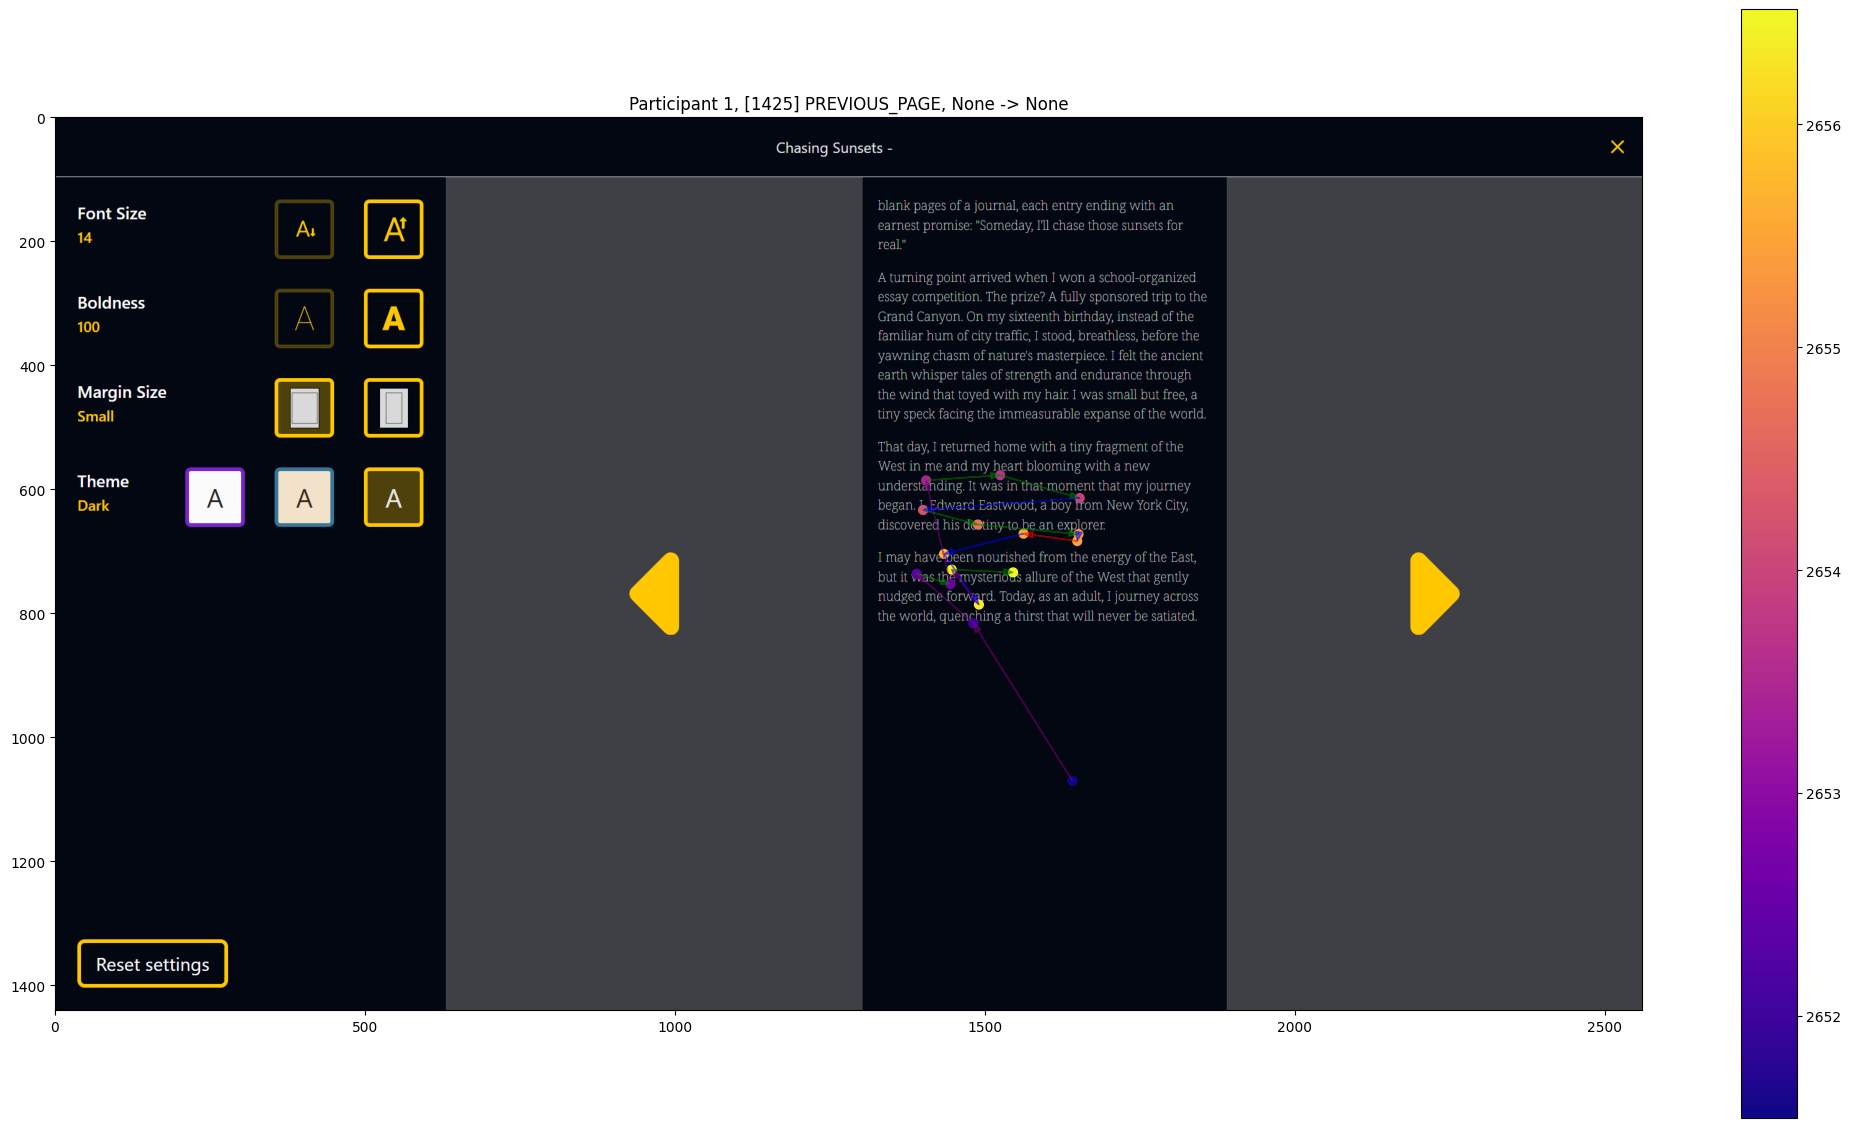

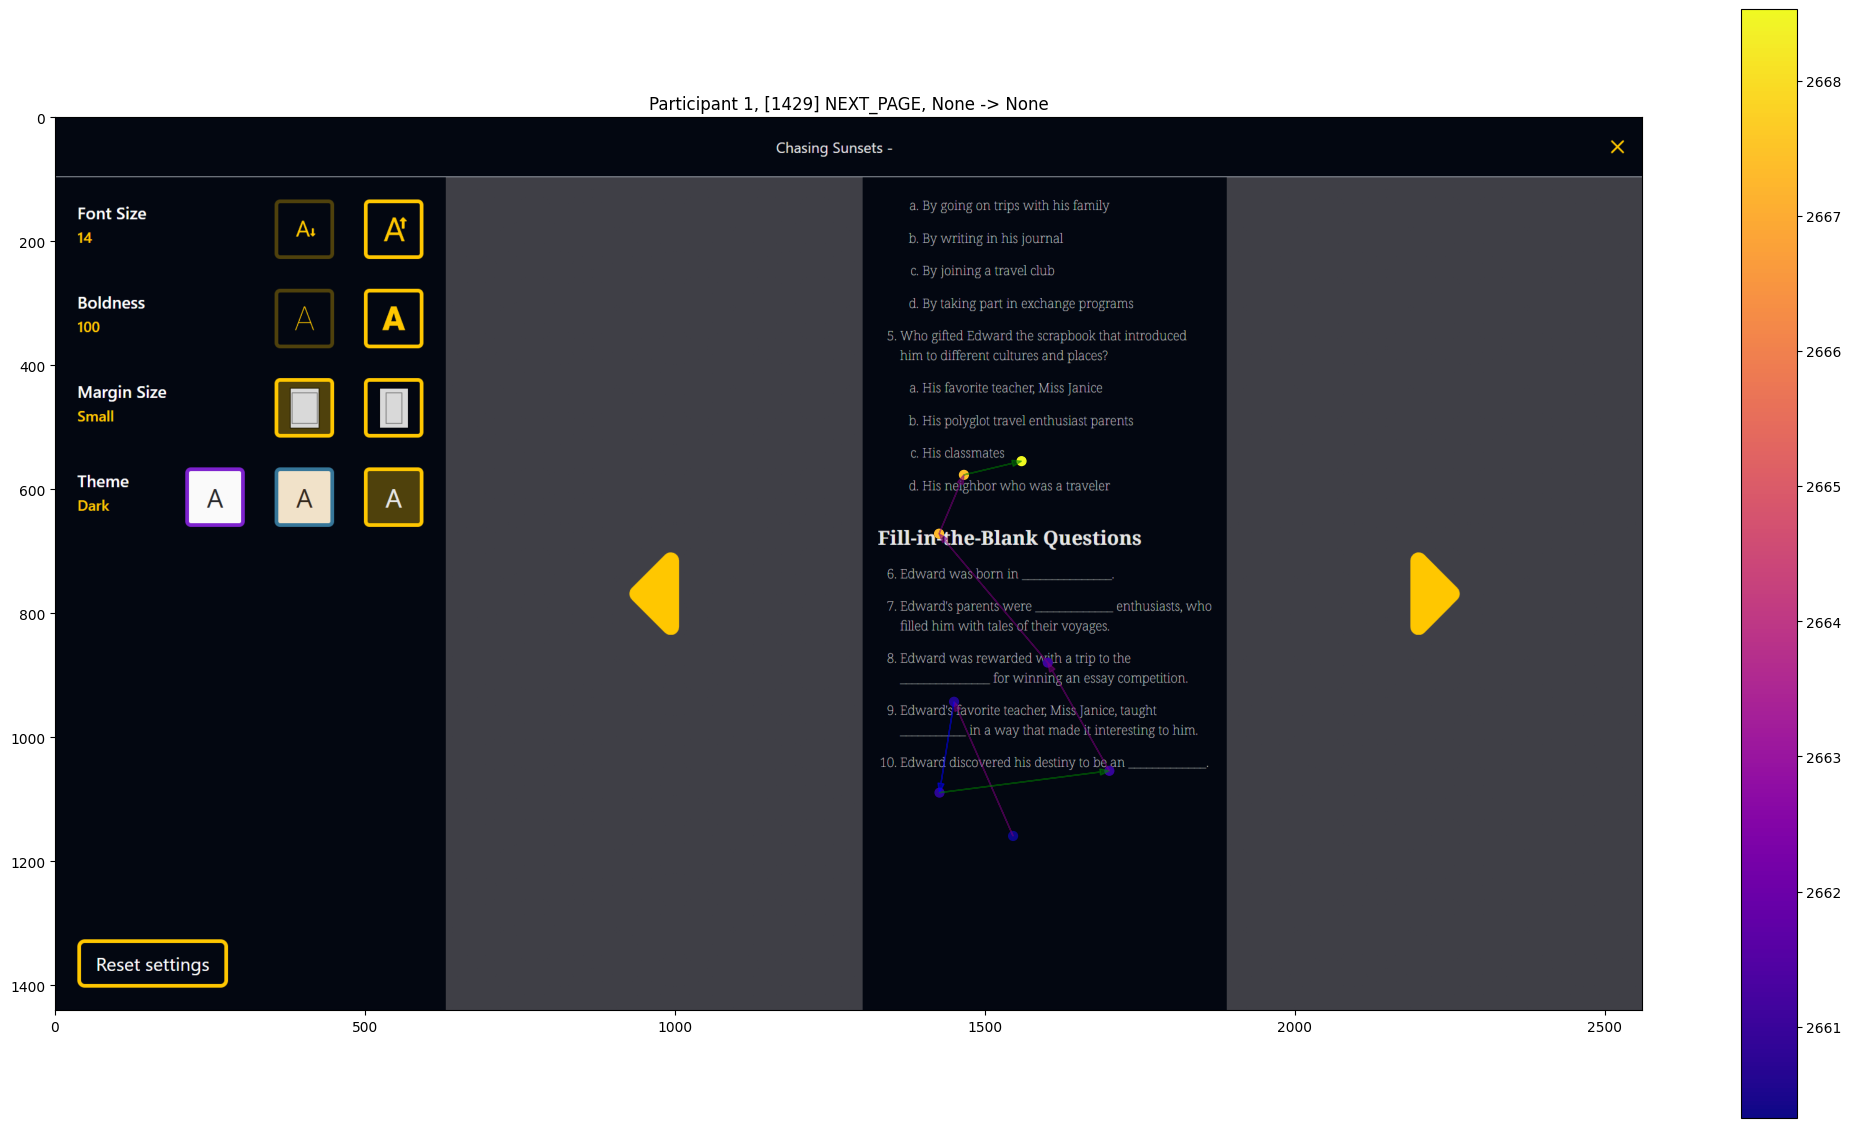

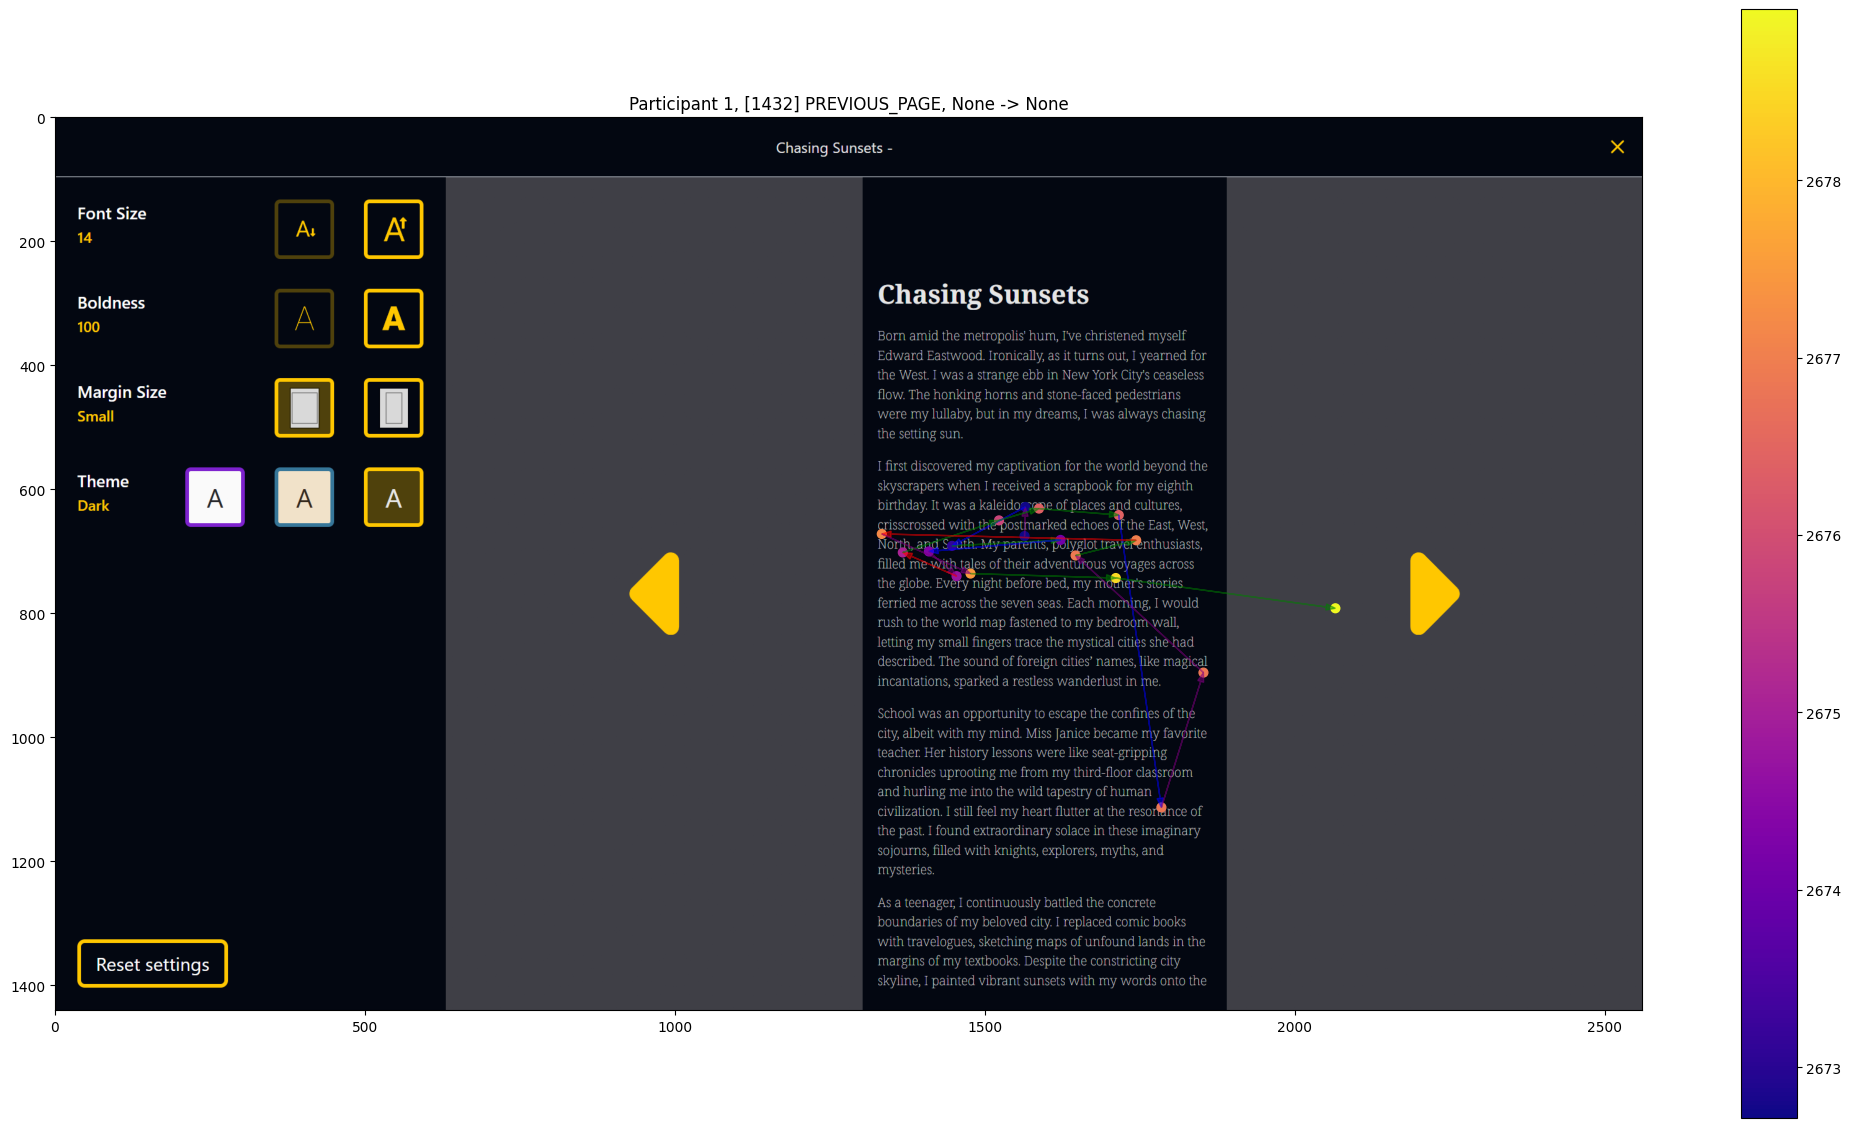

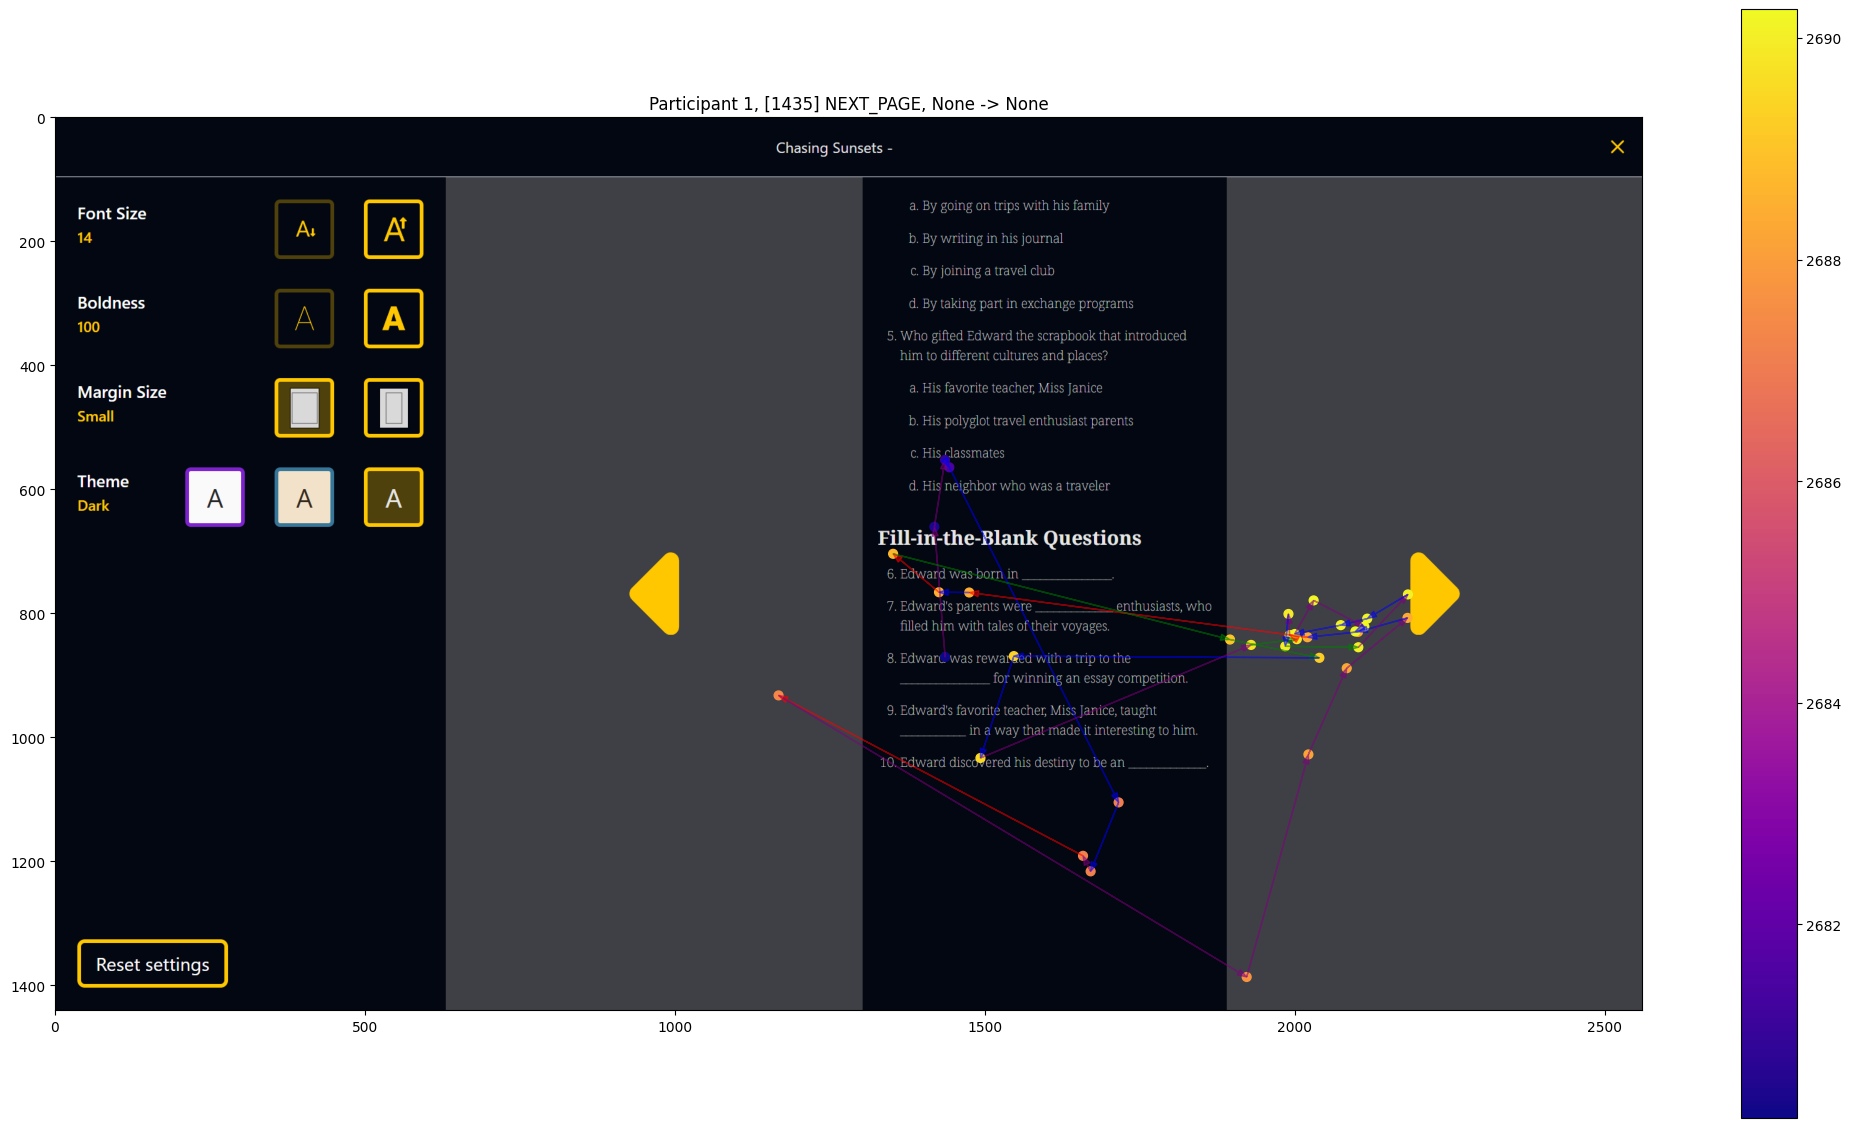

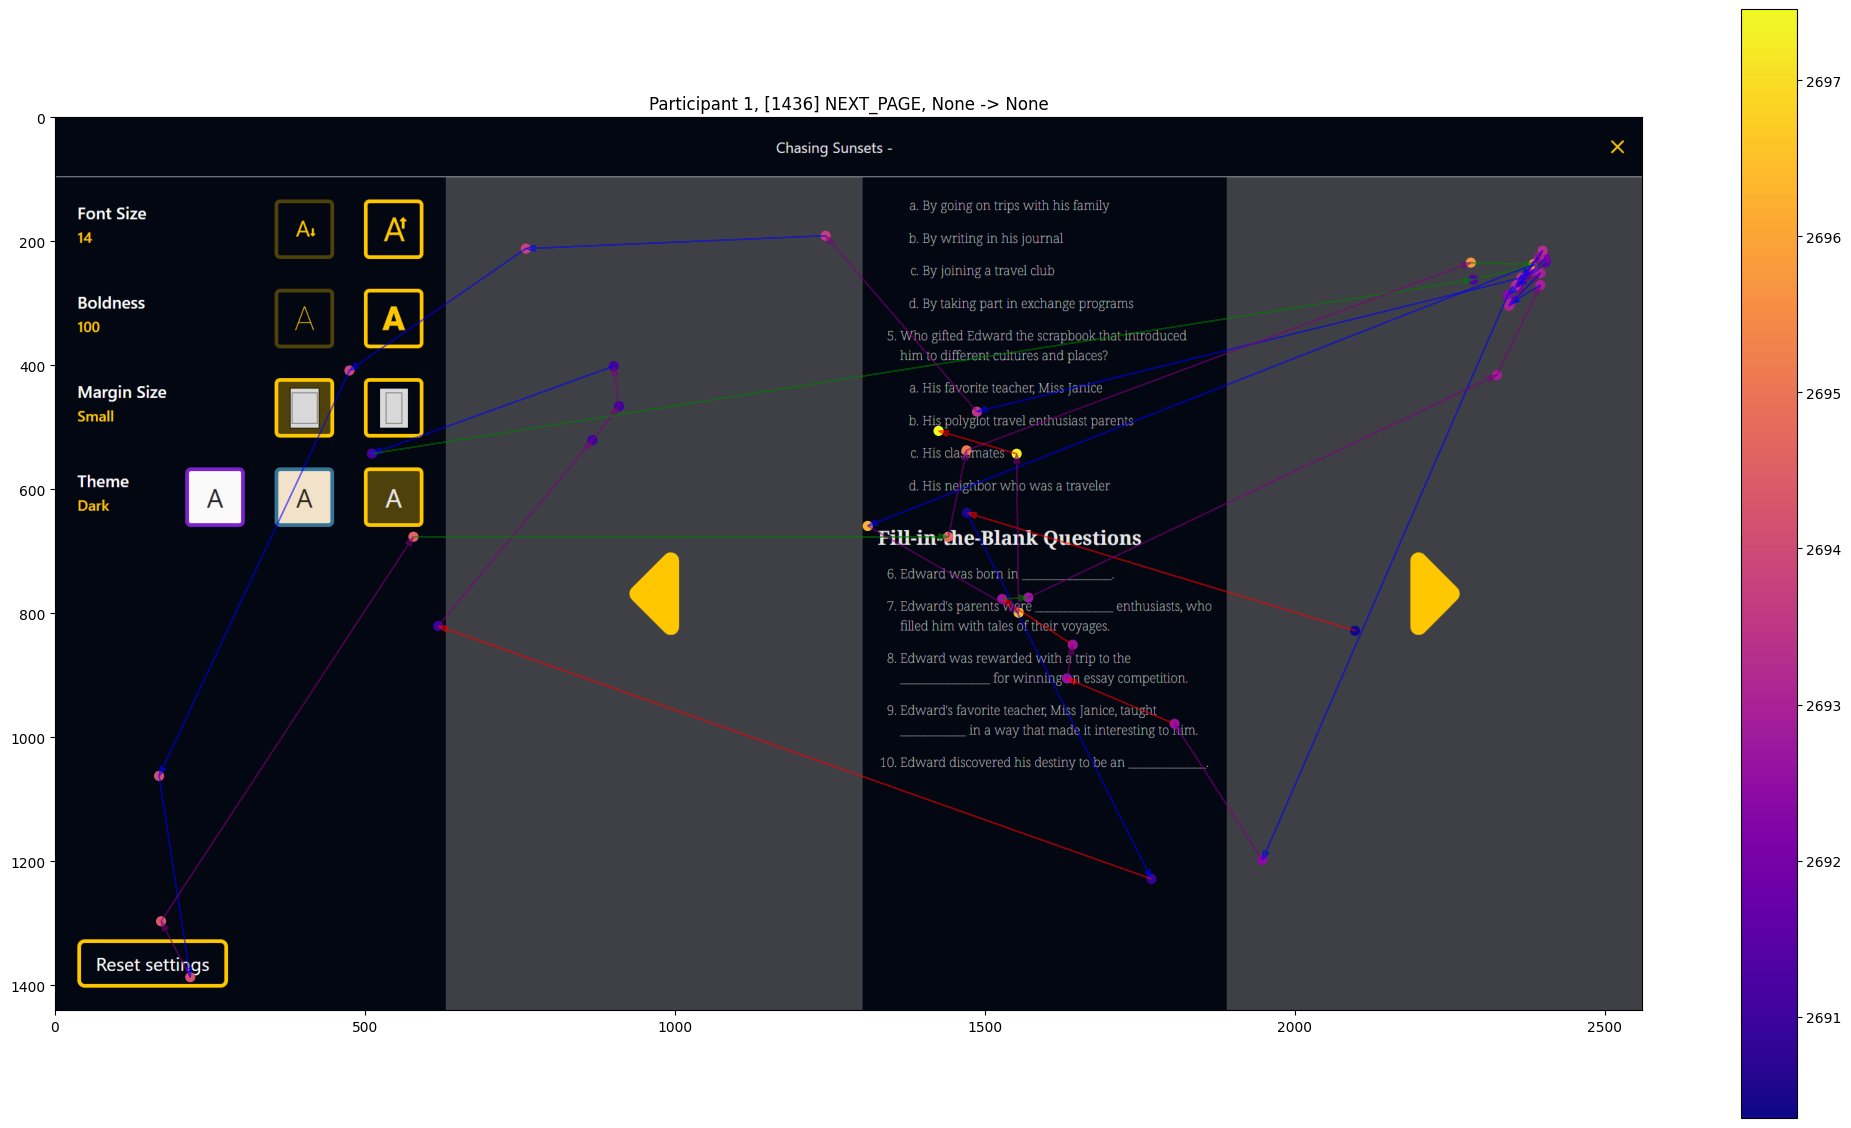

In [2]:
import os
from datetime import datetime

from utils import extract_gaze_data_between_timestamps_proper, plot_fixations_on_screenshot, print_record

# participants that were told that they can change the settings beforehand
participant_ids = [1]

# get the events
for participant in participant_ids:
  events = Events.select().where(Events.participant_id==participant)

  current_json_file = None
  batches_of_events = {}
  current_batch = []
  for event in events:
    if event.event == "SELECT_TREATMENT":
      continue
    elif event.event == "CLOSE_BOOK":
      current_batch.append(event)
      batches_of_events[current_json_file] = current_batch
      current_batch = []
    elif event.event == "OPEN_BOOK":
      timestamp = event.time
      date = datetime.fromtimestamp(timestamp /1000)
      date_string = date.strftime("%Y-%m-%d_%H-%M-%S")
      current_json_file = f"[{participant}]-{date_string}.json"
      current_batch.append(event)
    else:
      current_batch.append(event)

  # for each json file, get the gaze data
  for json_file, events in batches_of_events.items():
    # get the gaze data for this participant
    # the files are in eye_tracker_data/
    path = "eye_tracker_data/"

    # for start_event in events:
    gaze_data_filename = json_file
    gaze_data_filepath = os.path.join(path, gaze_data_filename)
    # Read the file
    import json
    with open(gaze_data_filepath, "r") as f:
      gaze_data = json.load(f)

    pairs = list(zip(events, events[1:]))
    for begin_page_event, end_page_event in pairs:
      T_start = begin_page_event.time
      T_end = end_page_event.time

      # ignore the event if the participant only looked at this page for less than 5 seconds
      if T_end - T_start < 5_000:
        continue
      gaze_data_between_pageturn_events = extract_gaze_data_between_timestamps_proper(gaze_data, T_start, T_end)
      screenshot_path = begin_page_event.screenshot_file
      SACCADIC_THRESHOLD = 160
      plot_fixations_on_screenshot(gaze_data_between_pageturn_events, screenshot_path, title=f"Participant {participant}, [{begin_page_event.id}] {begin_page_event.event}, {begin_page_event.old_value} -> {begin_page_event.new_value}", saccadic_threshold=SACCADIC_THRESHOLD)


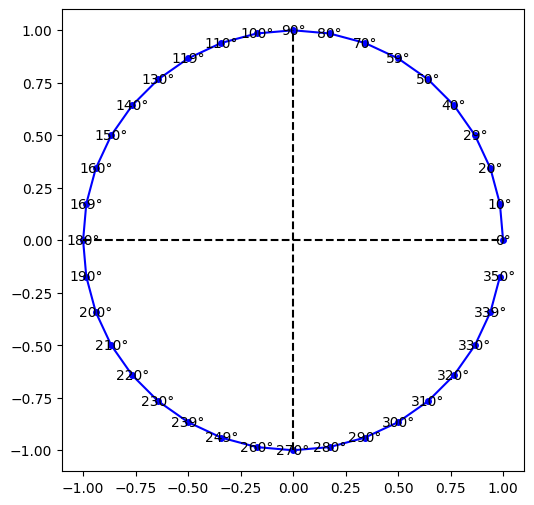

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Creating an array of angles in radians at 20-degree intervals
angles = np.arange(0, 2*np.pi, np.radians(10))

# Creating x and y coordinates for each angle
x = np.cos(angles)
y = np.sin(angles)

# Plotting the unit circle
plt.figure(figsize=(6, 6))
plt.plot(x, y, 'bo-', markersize=4)
plt.plot([0, 0], [-1, 1], 'k--')
plt.plot([-1, 1], [0, 0], 'k--')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')

# Adding angle labels
for i in range(len(angles)):
    plt.text(x[i], y[i], f'{int(np.degrees(angles[i]))}°', ha='center', va='center')

# Displaying the plot
plt.show()